In [1]:
import numpy as np
import scipy.optimize as opt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from teleportation import teleported_negativities_multi_gap_data

In [2]:
from time import time
import json
import pickle
import copy
import csv
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
from itertools import islice
from qiskit import transpile, ClassicalRegister
from qiskit.quantum_info import partial_trace, Statevector, DensityMatrix, Operator
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Batch, Sampler, Options
#from qiskit.providers.ibmq.managed import IBMQJobManager
from utilities import IBM_startup, bit_str_list, run_cal, load_cal
from teleportation import Teleportation, calc_negativities, calc_n_mean, calc_teleported_negativities, plot_teleported_negativities_multi_gap, teleported_negativities_multi_gap_data

hub = "ibm-q-melbourne"
group = "unimelb"
project = "hub"
backend_name = 'ibm_sherbrooke'
hgp = f"{hub}/{group}/{project}"

#provider = IBMProvider()
provider = IBM_startup()
backend = provider.get_backend(backend_name, instance=hgp)

Account enabled


In [3]:
def fit(x, m, c):
     return m*x + c
def log_fit(x, a, b):
     return a*np.log(x)+b

def logit_fit(x, a, b, c):
     return a/(1+np.exp((b*x+c)))

ibm_sherbrooke plots

[0.47135797 0.4466907  0.4351057  0.40318152 0.43229463 0.40360568
 0.39925493 0.34643464 0.31559443 0.21624412 0.21966299 0.18288691
 0.13143536 0.09789076 0.11719691 0.11314383 0.07646058 0.04480683
 0.        ]
[0.47906859 0.45718078 0.45634955 0.44157687 0.44042812 0.42281491
 0.41814373 0.39085776 0.40647608 0.36440982 0.29668423 0.23617984
 0.19276192 0.19604149 0.17342829 0.16507905 0.15257961 0.10188943
 0.10792068]
[0.47427978 0.45078969 0.44886615 0.42739971 0.43706776 0.41331452
 0.41162071 0.3642579  0.35971244 0.29222523 0.25925444 0.20749982
 0.15879143 0.14099531 0.13997063 0.14009538 0.1180661  0.06976478
 0.04737487]


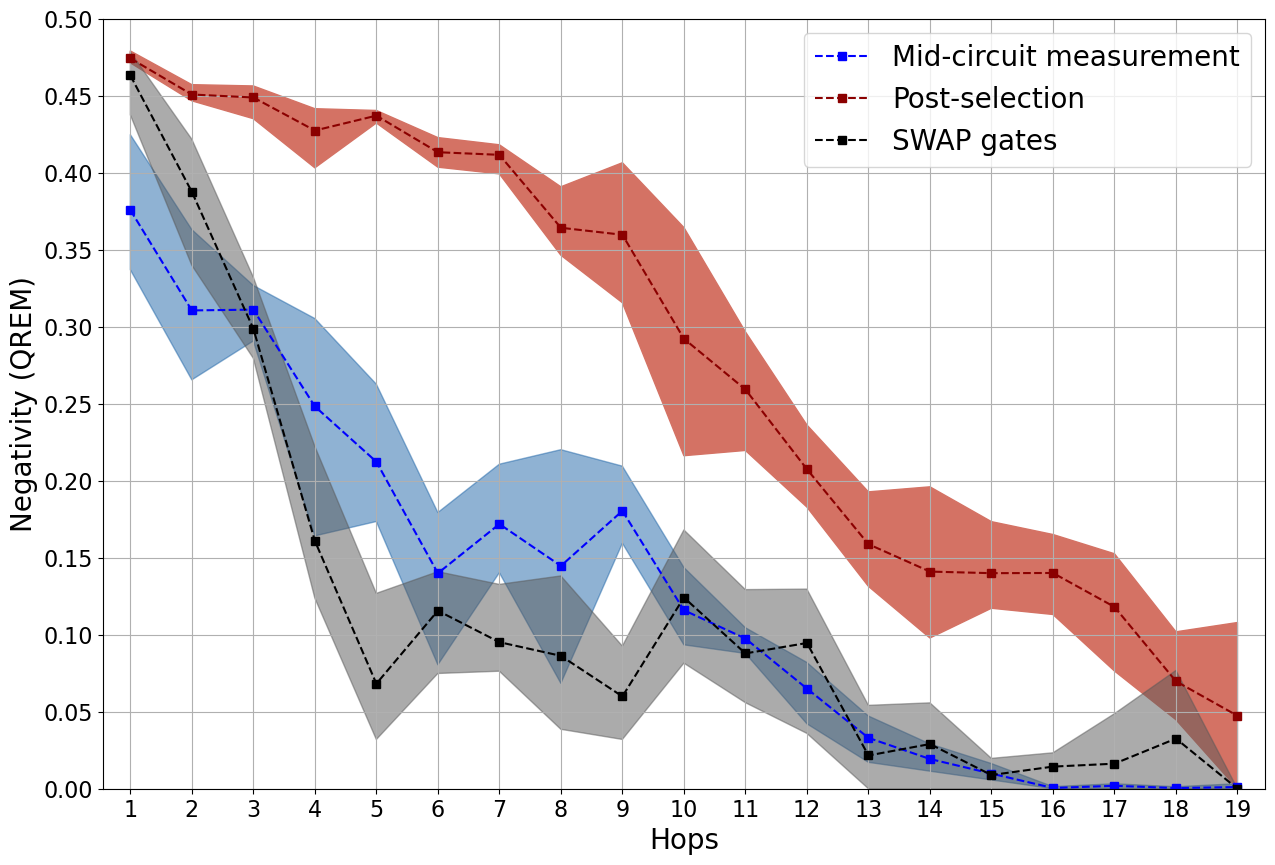

In [9]:
gaps = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
dyn_gate_opt = np.array([0.336993986, 0.265487585, 0.290739858, 0.164182295, 0.17350246, 0.08048024, 0.140266321, 0.068422553, 
                         0.159389734, 0.093436045, 0.100158219, 0.042157535, 0.034707266, 0.011392974, 0.007398152, 9.61E-05, 0, 0, 0])
dyn_gate_opt_std = np.array([0.032798432, 0.0262963, 0.006338855, 0.031659689, 0.015462042, 0.018925031, 0.017549077, 0.017305366, 
                             0.005387728, 0.012322388, 0.008824221, 0.010835447, 0.006978495, 0.003807398, 0.00400812, 9.30E-05, 0, 0, 0])
dyn_nmit_opt = np.array([0.365679403, 0.303197582, 0.315766579, 0.275273004, 0.20078297, 0.159947047, 0.210731104, 0.220155147, 0.209464771, 
                         0.143672253, 0.104554117, 0.081983044, 0.017140629, 0.029103508, 0.005702294, 0, 0.002451742, 0.001277982, 0])
dyn_nmit_opt_std = np.array([0.018890411, 0.021903251, 0.012031913, 0.012186292, 0.031209677, 0.022659929, 0.007700147, 0.007344089, 0.00591338, 
                             0.013724282, 0.017319238, 0.014157877, 0.00657174, 0.010459139, 0.003645571, 0, 0.001627098, 0.000656794, 0])
dyn_n_opt = np.array([0.424734529, 0.363053384, 0.326780374, 0.305321026, 0.262675029, 0.179347139, 0.16461422, 0.14544973, 0.172469935, 
                      0.110627227, 0.087840351, 0.07092106, 0.047208508, 0.017428493, 0.01634467, 0.001367696, 0.003222118, 0, 0.003258317])
dyn_n_opt_std = np.array([0.008536719, 0.009857565, 0.005346876, 0.009175427, 0.012165181, 0.021009604, 0.015148389, 0.024334434, 0.013922009, 
                          0.011565187, 0.006028611, 0.011138205, 0.006297029, 0.004362441, 0.003637325, 0.00076545, 0.001134253, 0, 0.002156902])

post_gate_opt = np.array([0.479068589, 0.44849758, 0.435105697, 0.437440733, 0.44042812, 0.422814906, 0.399254927, 0.346434643, 0.315594432, 
                          0.216244122, 0.219662991, 0.182886913, 0.131435358, 0.12905367, 0.129286691, 0.113143832, 0.076460582, 0.044806833, 0])

post_gate_opt_std = np.array([0.001587965, 0.002461736, 0.010655965, 0.002655224, 0.001997698, 0.00159902, 0.001423024, 0.003907535, 0.003609125, 
                              0.012886437, 0.004683603, 0.001937379, 0.010233115, 0.002153942, 0.001148638, 0.004732069, 0.011840492, 0.012286063, 0])

post_nmit_opt = np.array([0.472412786, 0.446690697, 0.45514319, 0.403181518, 0.432294635, 0.403605679, 0.418143728, 0.355481297, 0.406476081, 
                          0.364409823, 0.296684232, 0.203432712, 0.152177008, 0.097890761, 0.117196914, 0.142063258, 0.125158097, 0.062598068, 0.034203923])

post_nmit_opt_std = np.array([0.002259722, 0.00755982, 0.008879526, 0.013347267, 0.009972237, 0.008910638, 0.008302208, 0.025096101, 0.012815009, 
                              0.011285491, 0.02612414, 0.019521262, 0.020303185, 0.013321099, 0.011914518, 0.008247726, 0.009482338, 0.015624764, 0.014811267])

post_n_opt = np.array([0.471357975, 0.45718078, 0.456349553, 0.441576871, 0.438480523, 0.413522962, 0.417463461, 0.390857757, 0.357066819, 0.296021752, 
                       0.261416087, 0.236179838, 0.19276192, 0.196041493, 0.173428288, 0.165079049, 0.152579609, 0.101889426, 0.107920677])

post_n_opt_std = np.array([0.00329804, 0.001721942, 0.002482564, 0.002053461, 0.001692985, 0.003777504, 0.001978044, 0.002386222, 0.008473351, 
                           0.007486858, 0.00545746, 0.002257927, 0.001650114, 0.001859976, 0.001778022, 0.001283386, 0.00367188, 0.002267855, 0.002595185])

swap_gate_opt = np.array([0.47357151, 0.421765741, 0.332159397, 0.222296608, 0.126841247, 0.074837509, 0.076509743, 0.082095067, 0.032000377, 0.168024301, 
                          0.129292903, 0.129627171, 0.054138643, 0, 0, 0.019750981, 0, 0, 0])

swap_gate_opt_std = np.array([0.003003559, 0.004760157, 0.015741565, 0.023178836, 0.027606694, 0.032376865, 0.012224165, 0.012810235, 0.004414626, 
                              0.021402774, 0.029032807, 0.018802727, 0.011311328, 0, 0, 0.008554484, 0, 0, 0])

swap_nmit_opt = np.array([0.47841925, 0.401217653, 0.279492321, 0.136889626, 0.031951618, 0.131018463, 0.076304211, 0.038582902, 0.092640247, 
                          0.081542798, 0.078428237, 0.035929325, 0.010636648, 0.055758934, 0.006984914, 0, 6.44E-05, 0.020867569, 0])

swap_nmit_opt_std = np.array([0.003599165, 0.002508368, 0.015825156, 0.0106047, 0.008084435, 0.033673816, 0.029625508, 0.006756565, 0.025604852, 
                              0.021534704, 0.012073201, 0.009014437, 0.002456787, 0.009287072, 0.003086532, 0, 4.27E-05, 0.005294935, 0])

swap_n_opt = np.array([0.437554518, 0.339846411, 0.284486531, 0.123733919, 0.045777708, 0.140944155, 0.132690042, 0.138175934, 0.055169964, 0.122932146, 
                       0.055878468, 0.118322194, 0, 0.03125148, 0.019704487, 0.02331793, 0.048706763, 0.076790947, 0])

swap_n_opt_std = np.array([0.005049454, 0.021219007, 0.021325474, 0.035644283, 0.004072122, 0.019612059, 0.016333796, 0.012972129, 0.004135807, 
                           0.030178453, 0.024197103, 0.020780114, 0, 0.0089876, 0.008543473, 0.010098576, 0.011710861, 0.00587052, 0])


figsize = (15, 10)
fig, ax = plt.subplots(figsize = figsize)

#fitted_params_err_opt, pcov_err_opt = opt.curve_fit(logit_fit, gaps, n_err_opt, p0=[1,0.2,-1])
#fitted_params_nmit_opt, pcov_nmit_opt = opt.curve_fit(logit_fit, gaps, n_nmit_opt, p0=[1,0.2,-1])
#fitted_params_n_opt, pcov_n_opt = opt.curve_fit(logit_fit, gaps, n_n_opt, p0=[1,0.2,-1])
#print(fitted_params_err_opt)
#print(fitted_params_nmit_opt)
#print(fitted_params_n_opt)

#fit_gaps = np.linspace(1,20,1000)
#print(f'characteristic decay rate gate error optimal: {fitted_params_err_opt[1]}, standard error: {np.sqrt(pcov_err_opt[1][1])}')
#print(f'characteristic decay rate Nmit graph optimal: {fitted_params_nmit_opt[1]}, standard error: {np.sqrt(pcov_nmit_opt[1][1])}')
#print(f'characteristic decay rate N graph optimal: {fitted_params_n_opt[1]}, standard error: {np.sqrt(pcov_n_opt[1][1])}')

dyn_max = np.maximum(dyn_gate_opt, dyn_nmit_opt)
dyn_max = np.maximum(dyn_max, dyn_n_opt)
dyn_min = np.minimum(dyn_gate_opt, dyn_nmit_opt)
dyn_min = np.minimum(dyn_min, dyn_n_opt)
post_max = np.maximum(post_gate_opt, post_nmit_opt)
post_max = np.maximum(post_max, post_n_opt)
post_min = np.minimum(post_gate_opt, post_nmit_opt)
post_min = np.minimum(post_min, post_n_opt)
swap_max = np.maximum(swap_gate_opt, swap_nmit_opt)
swap_max = np.maximum(swap_max, swap_n_opt)
swap_min = np.minimum(swap_gate_opt, swap_nmit_opt)
swap_min = np.minimum(swap_min, swap_n_opt)

print(post_min)
print(post_max)
print((post_gate_opt+post_nmit_opt+post_n_opt)/3)
ax.plot(gaps, (dyn_gate_opt+dyn_nmit_opt+dyn_n_opt)/3, ls='dashed',
        label = 'Mid-circuit measurement', color = 'blue', marker = 's')
ax.plot(gaps, (post_gate_opt+post_nmit_opt+post_n_opt)/3, ls='dashed',
        label = 'Post-selection', color = 'darkred', marker = 's')
ax.plot(gaps, (swap_gate_opt+swap_nmit_opt+swap_n_opt)/3, ls='dashed',
        label = 'SWAP gates', color = 'black', marker = 's')

ax.fill_between(gaps, dyn_min, dyn_max, color = list(zip(['#2066a8']*19, [0.5]*19)))
ax.fill_between(gaps, post_min, post_max, color = list(zip(['#d47264']*19, [1]*19)))
ax.fill_between(gaps, swap_min, swap_max, color = list(zip(['#595959']*19, [0.5]*19)))
#ax.errorbar(gaps, dyn_gate_opt, yerr=2*np.array(dyn_gate_opt_std), capsize=3, ls='dashed',
#            label = 'Dynamic Circuits & 2-qubit gate error optimal', color = 'darkgreen', marker = 's')
#ax.errorbar(gaps, dyn_nmit_opt, yerr=2*np.array(dyn_nmit_opt_std), capsize=3, ls='dashed',
#            label = 'Dynamic Circuits & Mitigated Negativity optimal', color = 'limegreen', marker = 's')
#ax.errorbar(gaps, dyn_n_opt, yerr=2*np.array(dyn_n_opt_std), capsize=3, ls='dashed',
#            label = 'Dynamic Circuits & Unmitigated Negativity optimal', color = 'greenyellow', marker = 's')

#ax.errorbar(gaps, post_gate_opt, yerr=2*np.array(post_gate_opt_std), capsize=3, ls='dotted',
#            label = 'Pose-Selected & 2-qubit gate error optimal', color = 'darkred', marker = 'o')
#ax.errorbar(gaps, post_nmit_opt, yerr=2*np.array(post_nmit_opt_std), capsize=3, ls='dotted',
#            label = 'Pose-Selected & Mitigated Negativity optimal', color = 'red', marker = 'o')
#ax.errorbar(gaps, post_n_opt, yerr=2*np.array(post_n_opt_std), capsize=3, ls='dotted',
#            label = 'Pose-Selected & Unmitigated Negativity optimal', color = 'gold', marker = 'o')

#ax.errorbar(gaps, swap_gate_opt, yerr=2*np.array(swap_gate_opt_std), capsize=3, ls='dashdot',
#            label = 'SWAP gates & 2-qubit gate error optimal', color = 'darkblue', marker = '^')
#ax.errorbar(gaps, swap_nmit_opt, yerr=2*np.array(swap_nmit_opt_std), capsize=3, ls='dashdot',
#            label = 'SWAP gates & Mitigated Negativity optimal', color = 'blue', marker = '^')
#ax.errorbar(gaps, swap_n_opt, yerr=2*np.array(swap_n_opt_std), capsize=3, ls='dashdot',
#            label = 'SWAP gates & Unmitigated Negativity optimal', color = 'aqua', marker = '^')
#ax.plot(fit_gaps, logit_fit(fit_gaps, *fitted_params_err_opt), color = 'darkgreen', ls='dashed')
#ax.plot(fit_gaps, logit_fit(fit_gaps, *fitted_params_nmit_opt), color = 'limegreen', ls='dashed')
#ax.plot(fit_gaps, logit_fit(fit_gaps, *fitted_params_n_opt), color = 'greenyellow', ls='dashed')

#ax.axhline(y=0.5, color='black')
#ax.plot(net_error_fit, fit(net_error_fit, *fitted_params_Fid), color = 'red', linestyle = 'dashed')
#ax.plot(net_error_fit, fit(net_error_fit, *fitted_params_Fid_mit), color = 'blue', linestyle = 'dashed')
ax.set_xticks(np.arange(1, 20, 1))
ax.set_yticks(np.arange(0, 0.6, 0.05))
ax.set_ylim(bottom=0,top=0.5)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.grid()
ax.margins(0.025, 0.05)
ax.legend(fontsize=20)
ax.set_xlabel("Hops",fontsize=20)
ax.set_ylabel('Negativity (QREM)',fontsize=20)

fig.savefig('optimal paths/sherbrooke data/negativity mixed data new.pdf', dpi=300)

In [11]:
(post_gate_opt+post_nmit_opt+post_n_opt)/3

array([0.47427978, 0.45078969, 0.44886615, 0.42739971, 0.43706776,
       0.41331452, 0.41162071, 0.3642579 , 0.35971244, 0.29222523,
       0.25925444, 0.20749982, 0.15879143, 0.14099531, 0.13997063,
       0.14009538, 0.1180661 , 0.06976478, 0.04737487])

[0.8443199883333333, 0.7806307003333334, 0.7920113323333333, 0.702248488, 0.6774717453333334, 0.6174941103333333, 0.6606243906666666, 0.631738241, 0.665781818, 0.6176880306666667, 0.5987651996666666, 0.5401933233333333, 0.49027478566666666, 0.45531666899999995, 0.4422643583333333, 0.42215453566666666, 0.42256532133333335, 0.425131705, 0.39648316033333336]


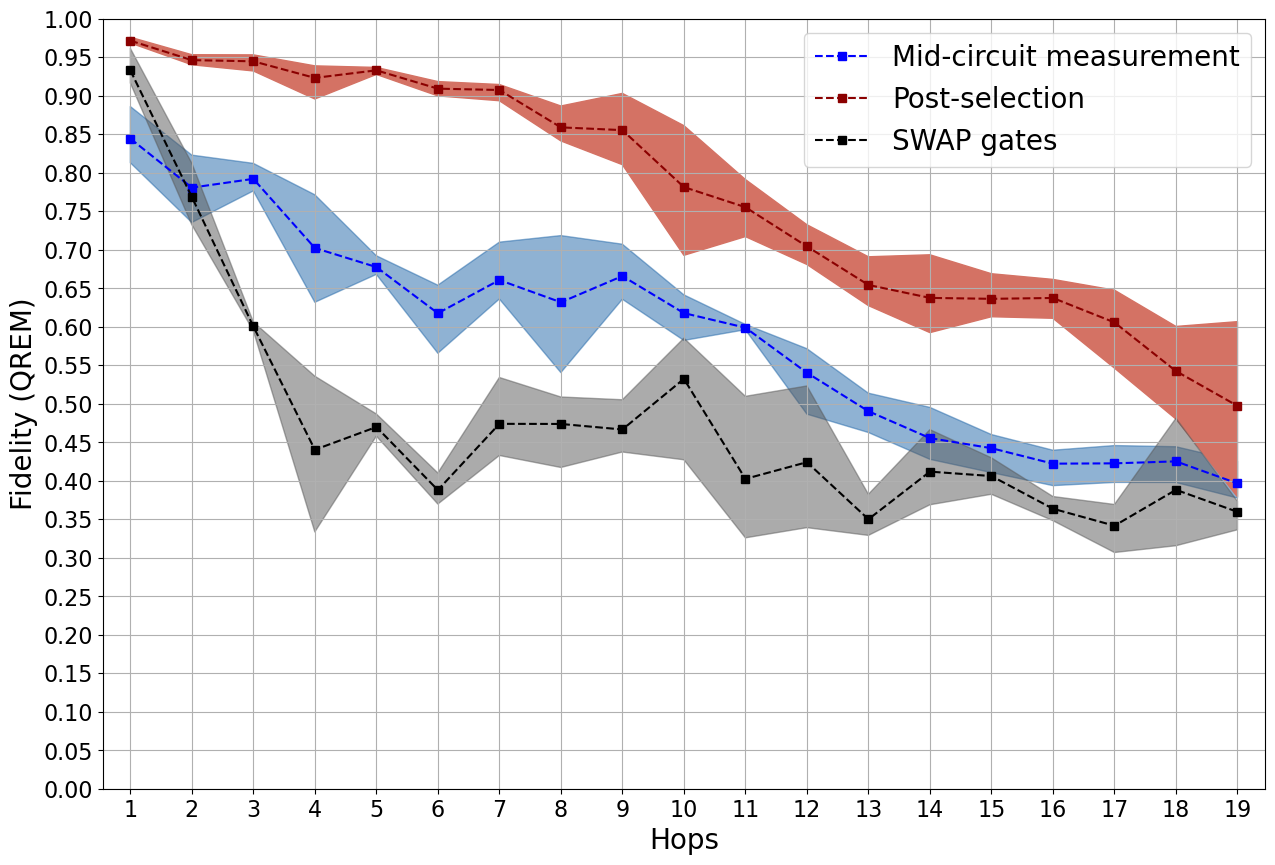

In [10]:
gaps = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
dyn_gate_opt = np.array([0.812926084, 0.735354165, 0.787532008, 0.631708249, 0.667943995, 0.565517508, 0.636018299, 0.540422515, 0.654499124, 
                         0.582171709, 0.597235449, 0.486467545, 0.494504279, 0.427764036, 0.410563194, 0.393602754, 0.397781575, 0.397734731, 0.425393223])
dyn_gate_opt_std = np.array([0.036440459, 0.034940005, 0.006515623, 0.042176271, 0.016159637, 0.02239653, 0.01726761, 0.023566668, 0.005153229, 
                             0.016401575, 0.008769724, 0.025641261, 0.017317623, 0.020253339, 0.019441838, 0.01860805, 0.006599322, 0.006123564, 0.007200676])
dyn_nmit_opt = np.array([0.834045697, 0.783685717, 0.812164693, 0.771360783, 0.692197677, 0.653953446, 0.709835108, 0.718348447, 0.707168591, 0.641392918, 
                         0.596084432, 0.571486002, 0.462612196, 0.49523878, 0.459969027, 0.439611815, 0.424241348, 0.433513361, 0.38655145])
dyn_nmit_opt_std = np.array([0.018962072, 0.020203955, 0.01244981, 0.01275177, 0.031730407, 0.02477229, 0.007675938, 0.007593509, 0.006324217, 
                             0.013853121, 0.019998496, 0.017276971, 0.017191501, 0.018069003, 0.013654143, 0.010672506, 0.01370979, 0.017384881, 0.009110529])
dyn_n_opt = np.array([0.885988184, 0.822852219, 0.776337296, 0.703676432, 0.672273564, 0.633011377, 0.636019765, 0.636443761, 0.635677739, 0.629499465, 
                      0.602975718, 0.562626423, 0.513707882, 0.442947191, 0.456260854, 0.433249038, 0.445673041, 0.444147023, 0.377504808])
dyn_n_opt_std = np.array([0.01163873, 0.014798795, 0.02438051, 0.026767898, 0.029935572, 0.025845352, 0.01241083, 0.016759988, 0.018660038, 0.017969807, 
                          0.01243162, 0.020457202, 0.017340117, 0.024870252, 0.021530825, 0.018466105, 0.020480565, 0.017476147, 0.018863607])

post_gate_opt = np.array([0.975970418, 0.94512592, 0.932170033, 0.934887449, 0.936743492, 0.918363153, 0.893507674, 0.841316678, 0.810458334, 
                          0.692764657, 0.717063571, 0.68089187, 0.627430053, 0.626540775, 0.62690842, 0.610971115, 0.546285663, 0.480078348, 0.37921407])

post_gate_opt_std = np.array([0.002013844, 0.002737466, 0.010391466, 0.002803134, 0.001794492, 0.001917183, 0.001100605, 0.003787381, 0.003425255, 
                              0.018316379, 0.004893504, 0.00196464, 0.010728294, 0.002214136, 0.001254348, 0.004713926, 0.023760426, 0.027730925, 0.007367727])

post_nmit_opt = np.array([0.970080207, 0.940228084, 0.948833182, 0.895761797, 0.927676487, 0.899800898, 0.914543639, 0.84873342, 0.903018051, 0.861116434, 
                          0.791156704, 0.699563451, 0.644476454, 0.5923616, 0.612977598, 0.639597143, 0.622986654, 0.546600959, 0.505833206])

post_nmit_opt_std = np.array([0.002556599, 0.006906123, 0.008349778, 0.014028003, 0.010192648, 0.008584924, 0.008484305, 0.026013653, 0.012506985, 
                              0.011145258, 0.026713661, 0.020004274, 0.020239734, 0.014032935, 0.012173728, 0.008426372, 0.009551527, 0.019256669, 0.018499053])

post_n_opt = np.array([0.968546448, 0.953262377, 0.953060281, 0.938773676, 0.934519909, 0.909361216, 0.914223094, 0.886643932, 0.852496703, 0.790166287, 
                       0.757501478, 0.732454068, 0.690825067, 0.693421082, 0.668807909, 0.661442335, 0.647481085, 0.600339044, 0.606584309])

post_n_opt_std = np.array([0.003480235, 0.001757865, 0.002475466, 0.001985521, 0.001717378, 0.003902698, 0.002053451, 0.00211923, 0.008232176, 
                           0.007373737, 0.005033975, 0.002260811, 0.001687187, 0.001979185, 0.001950168, 0.001661917, 0.003332958, 0.002227566, 0.002561086])

swap_gate_opt = np.array([0.92087219, 0.760807073, 0.594682526, 0.451482615, 0.464668081, 0.383903657, 0.454761629, 0.508747322, 0.437275739, 
                          0.584456063, 0.37177499, 0.410113763, 0.328992631, 0.368748147, 0.382385077, 0.348136525, 0.369167622, 0.367889567, 0.369085283])

swap_gate_opt_std = np.array([0.006710477, 0.00754957, 0.025229919, 0.036330931, 0.007895139, 0.019072152, 0.017865756, 0.017337942, 0.015621025, 
                              0.043000066, 0.037987773, 0.026020754, 0.007812404, 0.00396685, 0.005855233, 0.018144108, 0.002362024, 0.003693204, 0.009907308])

swap_nmit_opt = np.array([0.961539308, 0.812327201, 0.600164992, 0.535754199, 0.457891602, 0.41010889, 0.534083916, 0.417206389, 0.457157133, 
                          0.427183818, 0.325809945, 0.339051471, 0.338553421, 0.400344456, 0.42974909, 0.379486583, 0.348684506, 0.315563747, 0.33626611])

swap_nmit_opt_std = np.array([0.003004195, 0.013827446, 0.0166645, 0.00847826, 0.004772067, 0.04999908, 0.034642429, 0.012543549, 0.015148076, 0.037773716, 
                              0.02225223, 0.017824305, 0.010369448, 0.025909445, 0.011446121, 0.005589571, 0.014095295, 0.01591696, 0.011556359])

swap_n_opt = np.array([0.91651307, 0.732365148, 0.60619458, 0.33344569, 0.486720003, 0.36969706, 0.432773848, 0.495237457, 0.505157965, 0.585142674, 
                       0.509593724, 0.523053444, 0.382411261, 0.466319144, 0.406084328, 0.36327834, 0.306760034, 0.48112907, 0.373290374])

swap_n_opt_std = np.array([0.004388929, 0.017128736, 0.025613512, 0.032139563, 0.002291256, 0.040964852, 0.031253767, 0.015807037, 0.007464659, 
                           0.033458173, 0.026074169, 0.03132879, 0.006182997, 0.016289508, 0.005605769, 0.012166476, 0.028050178, 0.004108613, 0.002391336])


figsize = (15, 10)
fig, ax = plt.subplots(figsize = figsize)

#fitted_params_err_opt, pcov_err_opt = opt.curve_fit(logit_fit, gaps, n_err_opt, p0=[1,0.2,-1])
#fitted_params_nmit_opt, pcov_nmit_opt = opt.curve_fit(logit_fit, gaps, n_nmit_opt, p0=[1,0.2,-1])
#fitted_params_n_opt, pcov_n_opt = opt.curve_fit(logit_fit, gaps, n_n_opt, p0=[1,0.2,-1])
#print(fitted_params_err_opt)
#print(fitted_params_nmit_opt)
#print(fitted_params_n_opt)

#fit_gaps = np.linspace(1,20,1000)
#print(f'characteristic decay rate gate error optimal: {fitted_params_err_opt[1]}, standard error: {np.sqrt(pcov_err_opt[1][1])}')
#print(f'characteristic decay rate Nmit graph optimal: {fitted_params_nmit_opt[1]}, standard error: {np.sqrt(pcov_nmit_opt[1][1])}')
#print(f'characteristic decay rate N graph optimal: {fitted_params_n_opt[1]}, standard error: {np.sqrt(pcov_n_opt[1][1])}')

dyn_max = np.maximum(dyn_gate_opt, dyn_nmit_opt)
dyn_max = np.maximum(dyn_max, dyn_n_opt)
dyn_min = np.minimum(dyn_gate_opt, dyn_nmit_opt)
dyn_min = np.minimum(dyn_min, dyn_n_opt)
post_max = np.maximum(post_gate_opt, post_nmit_opt)
post_max = np.maximum(post_max, post_n_opt)
post_min = np.minimum(post_gate_opt, post_nmit_opt)
post_min = np.minimum(post_min, post_n_opt)
swap_max = np.maximum(swap_gate_opt, swap_nmit_opt)
swap_max = np.maximum(swap_max, swap_n_opt)
swap_min = np.minimum(swap_gate_opt, swap_nmit_opt)
swap_min = np.minimum(swap_min, swap_n_opt)

print(list((dyn_gate_opt+dyn_nmit_opt+dyn_n_opt)/3))
ax.plot(gaps, (dyn_gate_opt+dyn_nmit_opt+dyn_n_opt)/3, ls='dashed',
        label = 'Mid-circuit measurement', color = 'blue', marker = 's')
ax.plot(gaps, (post_gate_opt+post_nmit_opt+post_n_opt)/3, ls='dashed',
        label = 'Post-selection', color = 'darkred', marker = 's')
ax.plot(gaps, (swap_gate_opt+swap_nmit_opt+swap_n_opt)/3, ls='dashed',
        label = 'SWAP gates', color = 'black', marker = 's')

ax.fill_between(gaps, dyn_min, dyn_max, color = list(zip(['#2066a8']*19, [0.5]*19)))
ax.fill_between(gaps, post_min, post_max, color = list(zip(['#d47264']*19, [1]*19)))
ax.fill_between(gaps, swap_min, swap_max, color = list(zip(['#595959']*19, [0.5]*19)))
#ax.errorbar(gaps, dyn_gate_opt, yerr=2*np.array(dyn_gate_opt_std), capsize=3, ls='dashed',
#            label = 'Dynamic Circuits & 2-qubit gate error optimal', color = 'darkgreen', marker = 's')
#ax.errorbar(gaps, dyn_nmit_opt, yerr=2*np.array(dyn_nmit_opt_std), capsize=3, ls='dashed',
#            label = 'Dynamic Circuits & Mitigated Negativity optimal', color = 'limegreen', marker = 's')
#ax.errorbar(gaps, dyn_n_opt, yerr=2*np.array(dyn_n_opt_std), capsize=3, ls='dashed',
#            label = 'Dynamic Circuits & Unmitigated Negativity optimal', color = 'greenyellow', marker = 's')

#ax.errorbar(gaps, post_gate_opt, yerr=2*np.array(post_gate_opt_std), capsize=3, ls='dotted',
#            label = 'Pose-Selected & 2-qubit gate error optimal', color = 'darkred', marker = 'o')
#ax.errorbar(gaps, post_nmit_opt, yerr=2*np.array(post_nmit_opt_std), capsize=3, ls='dotted',
#            label = 'Pose-Selected & Mitigated Negativity optimal', color = 'red', marker = 'o')
#ax.errorbar(gaps, post_n_opt, yerr=2*np.array(post_n_opt_std), capsize=3, ls='dotted',
#            label = 'Pose-Selected & Unmitigated Negativity optimal', color = 'gold', marker = 'o')

#ax.errorbar(gaps, swap_gate_opt, yerr=2*np.array(swap_gate_opt_std), capsize=3, ls='dashdot',
#            label = 'SWAP gates & 2-qubit gate error optimal', color = 'darkblue', marker = '^')
#ax.errorbar(gaps, swap_nmit_opt, yerr=2*np.array(swap_nmit_opt_std), capsize=3, ls='dashdot',
#            label = 'SWAP gates & Mitigated Negativity optimal', color = 'blue', marker = '^')
#ax.errorbar(gaps, swap_n_opt, yerr=2*np.array(swap_n_opt_std), capsize=3, ls='dashdot',
#            label = 'SWAP gates & Unmitigated Negativity optimal', color = 'aqua', marker = '^')
#ax.plot(fit_gaps, logit_fit(fit_gaps, *fitted_params_err_opt), color = 'darkgreen', ls='dashed')
#ax.plot(fit_gaps, logit_fit(fit_gaps, *fitted_params_nmit_opt), color = 'limegreen', ls='dashed')
#ax.plot(fit_gaps, logit_fit(fit_gaps, *fitted_params_n_opt), color = 'greenyellow', ls='dashed')

#ax.axhline(y=0.5, color='black')
#ax.plot(net_error_fit, fit(net_error_fit, *fitted_params_Fid), color = 'red', linestyle = 'dashed')
#ax.plot(net_error_fit, fit(net_error_fit, *fitted_params_Fid_mit), color = 'blue', linestyle = 'dashed')
ax.set_xticks(np.arange(1, 20, 1))
ax.set_yticks(np.arange(0, 1.1, 0.05))
ax.set_ylim(bottom=0,top=1)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.grid()
ax.margins(0.025, 0.05)
ax.legend(fontsize=20)
ax.set_xlabel("Hops",fontsize=20)
ax.set_ylabel('Fidelity (QREM)',fontsize=20)

fig.savefig('optimal paths/sherbrooke data/fidelity mixed data new.pdf', dpi=300)

Post-selection, 3 optimal protocols, Nmit plot

In [27]:
#Unmitigated Results
gaps = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

#post1_gate_opt = [0.435152303, 0.414341794, 0.377090348, 0.340427031, 0.314199837, 0.316877516, 0.243770163, 0.234633568, 0.168332805, 0.148631098,
#                  0.16707101, 0.163074714, 0.157138149, 0.136248448, 0.129317078, 0.076958738, 0.017201455, 0.004963918, 0.006215156]

#post1_gate_opt_err = [0.003520198, 0.003932454, 0.010430292, 0.011838255, 0.011766987, 0.002918987, 0.017129665, 0.010117212, 0.006750568, 0.011139724,
#                      0.014971394, 0.006475049, 0.005702969, 0.004735401, 0.004767476, 0.012781051, 0.006537184, 0.001730097, 0.001894126]

#post2_gate_opt = [0.441636569, 0.416683876, 0.376074557, 0.33978277, 0.314557237, 0.320994272, 0.246630864, 0.23599584, 0.165303524, 0.144671288,
#                  0.164619592, 0.160212347, 0.154017388, 0.136727907, 0.127048107, 0.077438931, 0.014962671, 0.003908377, 0.006750209]

#post2_gate_opt_err = [0.004673807, 0.004115188, 0.010155374, 0.011989726, 0.011367188, 0.003631253, 0.017111216, 0.008743315, 0.006489605, 0.011724536,
#                      0.013208357, 0.005800284, 0.004970899, 0.005017916, 0.005972679, 0.010892854, 0.006381452, 0.001469171, 0.002216001]

#post3_gate_opt = [0, 0.419993941, 0.378652736, 0.340871056, 0.315755362, 0.317535771, 0.25050048, 0.234526351, 0.169029289, 0.147513019,
#                  0.166773878, 0.163213238, 0.157130268, 0.138822356, 0.124762818, 0.075148015, 0.019135684, 0.004388607, 0.005115528]

#post3_gate_opt_err = [0, 0.003351802, 0.011313926, 0.011392928, 0.01137275, 0.003395793, 0.016335024, 0.00966109, 0.005788003, 0.010326155, 
#                      0.014456236, 0.006192518, 0.004571778, 0.005078406, 0.005457858, 0.012064506, 0.008217203, 0.001616546, 0.001571119]

#post4_gate_opt = [0, 0.419990321, 0.381598692, 0.337767238, 0.318814293, 0.317759284, 0.246439176, 0.234266968, 0.164264682, 0.150676235,
#                  0.167646437, 0.158414737, 0.159519995, 0.137482647, 0.12926247, 0.07757982, 0.017118925, 0.005616276, 0.006579367]

#post4_gate_opt_err = [0, 0.004024672, 0.010444478, 0.012009169, 0.011737425, 0.002629951, 0.017493296, 0.009950041, 0.005967884, 0.010085803,
#                      0.014084074, 0.006922248, 0.00528411, 0.004541805, 0.005795249, 0.011863886, 0.00729125, 0.002096512, 0.002279693]

#post_gate_opt = [0.438394436, 0.417752483, 0.378354083, 0.339712024, 0.315831683, 0.318291711, 0.246835171, 0.234855682, 0.166732575, 
#                 0.14787291, 0.166527729, 0.161228759, 0.15695145, 0.137320339, 0.127597618, 0.076781376, 0.017104684, 0.004719295, 0.006165065]

#post_gate_opt_err = [0.003521871, 0.003611941, 0.010530247, 0.011757993, 0.011510146, 0.002808282, 0.016939296, 0.009414878, 0.005900444, 0.010689115,
#                     0.014072103, 0.006071835, 0.00479491, 0.004580451, 0.005277666, 0.011763524, 0.007029188, 0.001437084, 0.001606834]


#post1_n_opt = [0.435514122, 0.430958016, 0.408639669, 0.37724028, 0.368069961, 0.33513738, 0.32327177, 0.319848814, 0.291224515, 0.244945164, 
#               0.243742711, 0.210217019, 0.197921652, 0.169822867, 0.179175446, 0.114103507, 0.038637528, 0.000484406, 0.000548444]

#post1_n_opt_err = [0.002375943, 0.001446174, 0.002634758, 0.0028036, 0.002218529, 0.003736499, 0.003528355, 0.004324891, 0.003108153, 0.005259012, 
#                   0.003622297, 0.003297938, 0.003849673, 0.001958273, 0.00376482, 0.005362756, 0.008341816, 0.000469025, 0.000531029]

#post2_n_opt = [0.430365567, 0.434291518, 0.40595311, 0.380263094, 0.366969014, 0.336659566, 0.327595602, 0.31860085, 0.288264475, 0.246479184, 
#               0.241271365, 0.208577122, 0.196832975, 0.165813526, 0.177705565, 0.112274189, 0.04146731, 1.22e-5, 8.70e-6]

#post2_n_opt_err = [0.004033598, 0.001533091, 0.003054247, 0.003056444, 0.002382484, 0.003468109, 0.003095627, 0.004830537, 0.003252691, 0.005180819,
#                   0.003320211, 0.002962594, 0.003327733, 0.0038781, 0.003712323, 0.005865449, 0.008689176, 1.18e-05, 8.42e-06]

#post3_n_opt = [0, 0.432223075, 0.409943869, 0.381158536, 0.367861209, 0.335516079, 0.327798531,0.317857964, 0.288852561, 0.24236979, 0.24062914,
#               0.209052694, 0.196915921, 0.170724845, 0.180279033, 0.113242252, 0.044023678, 0, 0.000157507]

#post3_n_opt_err = [0, 0.001759865, 0.003489507, 0.002361016, 0.002145434, 0.003297951, 0.003729872, 0.0046826, 0.003385814, 0.004250214, 0.004653681, 
#                   0.002341975, 0.003176307, 0.002688505, 0.002890487, 0.005622739, 0.008563754, 0, 0.000107913]

#post4_n_opt = [0, 0.434028754, 0.409165668, 0.38194096, 0.368018593, 0.335163619, 0.32679245, 0.316675831, 0.289220188, 0.246610107, 0.2445089, 0.20904737, 
#               0.202026369, 0.172266779, 0.179353097, 0.110716763, 0.0471541, 0.000330472, 0]

#post4_n_opt_err = [0, 0.001595043, 0.002968526, 0.002841597, 0.001992762, 0.004029531, 0.003595658, 0.005210636, 0.00341621, 0.005304943, 0.003581055, 
#                   0.003533292, 0.003182981,0.003089151, 0.002832722, 0.00476749, 0.008753839, 0.000319978, 0]

#post_n_opt = [0.432939845, 0.432875341, 0.408425579, 0.380150718, 0.367729694, 0.335619161, 0.326364588, 0.318245865, 0.289390435, 0.245101062, 
#              0.242538029, 0.209223551, 0.198424229, 0.169657004, 0.179128285, 0.112584178, 0.042820654, 0.000206772, 0.000178662]

#post_n_opt_err = [0.002457632, 0.001102628, 0.002900669, 0.002547653, 0.001904899, 0.003455251, 0.003251334, 0.004601239, 0.002926916, 0.004791496, 
#                  0.003491039, 0.002630895, 0.002701878, 0.002279875, 0.002863222, 0.00517237, 0.008432336, 0.000139043, 0.000132793]



#post1_nmit_opt = [0.386730798, 0.328806677, 0.238888597, 0.195632048, 0.221443657, 0.118490867, 0.154605813, 0.17682478, 0.138549516,
#                  0.112386412, 0.124087737, 0.1068805, 0.116957555, 0.107617279, 0.108579058, 0.05947925, 0.024683339, 0.029613396, 0.024640039]

#post1_nmit_opt_err = [0.009644375, 0.009834048, 0.024927696, 0.02521024, 0.018927491, 0.007316186, 0.01854756, 0.015413129, 0.019221263, 0.014628001, 
#                      0.01495278, 0.018620131, 0.019163646, 0.017742755, 0.012862767, 0.011175892, 0.008932259, 0.01286919, 0.006085405]

#post2_nmit_opt = [0.382080684, 0.336040598, 0.240056088, 0.199212074, 0.220192257, 0.119170274, 0.153518135, 0.17728366, 0.137730122, 
#                  0.112431797, 0.121154143, 0.106396657, 0.120099466, 0.108840469, 0.109200943, 0.058354931, 0.02609125, 0.02777932, 0.024143633]

#post2_nmit_opt_err = [0.010390395, 0.011833895, 0.024625794, 0.024930493, 0.018777097, 0.006796445, 0.018816909, 0.015034316, 0.018913631, 
#                      0.014503635, 0.014678006, 0.019159861, 0.019133356, 0.018047351, 0.013625305, 0.01177655, 0.008881214, 0.012067011, 0.006018809]

#post3_nmit_opt = [0, 0.327768313, 0.236524883, 0.193824756, 0.225849769, 0.121484724, 0.158091947, 0.17624797, 0.137671238, 0.11821228, 0.120468268, 
#                  0.105299666, 0.118179154, 0.105254833, 0.106778767, 0.059987619, 0.02698085, 0.027094235, 0.022479573]

#post3_nmit_opt_err = [0, 0.013191853, 0.023783279, 0.025639464, 0.019721214, 0.007813888, 0.018922871, 0.016326367, 0.018963525, 0.015101609, 
#                      0.015036813, 0.018729411, 0.019094201, 0.01814507, 0.013970429, 0.011631027, 0.008799191, 0.011828503, 0.005738953]

#post4_nmit_opt = [0, 0.339349747, 0.237750396, 0.198303137, 0.221050571, 0.120900389, 0.156647878, 0.176564709, 0.135500489, 0.111232968, 0.121974777, 
#                  0.103694183, 0.118582736, 0.108235501, 0.110116296, 0.057748972, 0.026453577, 0.028471107, 0.025458635]

#post4_nmit_opt_err = [0, 0.011420011, 0.024772074, 0.024880798, 0.018973057, 0.007880794, 0.018210638, 0.015324205, 0.01939317, 0.015313008, 
#                      0.014146156, 0.019724164, 0.018714565, 0.01749126, 0.013929765, 0.011294278, 0.009515051, 0.012366711, 0.006604241]

#post_nmit_opt = [0.384405741, 0.332991334, 0.238304991, 0.196743004, 0.222134063, 0.120011563, 0.155715943, 0.17673028, 0.137362841, 0.113565865, 
#                 0.121921231, 0.105567752, 0.118454728, 0.10748702, 0.108668766, 0.058892693, 0.026052254, 0.028239514, 0.02418047]

#post_nmit_opt_err = [0.00997237, 0.011417728, 0.024478884, 0.025102323, 0.019050977, 0.007299415, 0.01856597, 0.015426383, 0.019040521, 0.014808513,
#                     0.014643788, 0.019003676, 0.018938306, 0.017755317, 0.013518788, 0.01134124, 0.008945658, 0.012231838, 0.005989057]



#New Unmitigated Results
post1_gate_opt = [0.439988039, 0.408229022, 0.391031625, 0.407333371, 0.400735595, 0.380941127, 0.340316279, 0.282406359, 0.25028349, 0.131647319,
                  0.169841737, 0.156539519, 0.116742872, 0.119183823, 0.123412213, 0.112106333, 0.076627547, 0.046211645, 0]

post1_gate_opt_err = [0.007824808, 0.007465188, 0.017071873, 0.002469978, 0.003196069, 0.002546152, 0.005075309, 0.008494499, 0.005035771, 0.0244699,
                      0.006980377, 0.001881974, 0.009816499, 0.002426227, 0.001119834, 0.004698337, 0.011985089, 0.01245713, 0]

post2_gate_opt = [0.449991246, 0.415218193, 0.391696149, 0.408585696, 0.39941179, 0.379885173, 0.337821744, 0.287107605, 0.250210041, 0.130632803, 
                  0.170717933, 0.154896891, 0.118813456, 0.122662542, 0.125696873, 0.111872083, 0.072635583, 0.041844355, 0]

post2_gate_opt_err = [0.005830773, 0.005252886, 0.017034527, 0.002404126, 0.003332795, 0.003082679, 0.004951831, 0.006970803, 0.004915421,
                      0.024093594, 0.006233654, 0.002621048, 0.010128104, 0.002891587, 0.002859085, 0.005329681, 0.011419908, 0.011987212, 0]

post3_gate_opt = [0, 0.420855597, 0.394447821, 0.409012377, 0.400316263, 0.379352894, 0.336965039, 0.284723335, 0.250917622, 0.132548775, 
                  0.173098279, 0.156052878, 0.117829872, 0.122024179, 0.123337402, 0.111620958, 0.076797708, 0.044477853, 0]

post3_gate_opt_err = [0, 0.005708979, 0.01753788, 0.002908242, 0.003151748, 0.003076161, 0.00497551, 0.007568361, 0.004370145, 0.024118217, 
                      0.006077259, 0.001987634, 0.010789791, 0.002431291, 0.002411231, 0.004793046, 0.011937031, 0.012077655, 0]

post4_gate_opt = [0, 0.426025098, 0.39446891, 0.410117728, 0.400987527, 0.382507337, 0.340833989, 0.284864508, 0.251869229, 0.131451583, 
                  0.173560058, 0.156843035, 0.113492139, 0.12159004, 0.126788039, 0.108657861, 0.076851825, 0.044978108, 0]

post4_gate_opt_err = [0, 0.00389448, 0.017588413, 0.002459486, 0.002894189, 0.003552759, 0.00525186, 0.007114856, 0.005412749, 0.024163944, 0.006959768,
                      0.001986895, 0.010359795, 0.002126341, 0.001756468, 0.005353375, 0.012064428, 0.012522626, 0]

post_gate_opt = [0.444989642, 0.417581978, 0.392911126, 0.408762293, 0.400362794, 0.380671633, 0.338984263, 0.284775452, 0.250820096, 0.13157012, 
                 0.171804502, 0.156083081, 0.116719585, 0.121365146, 0.124808632, 0.111064309, 0.075728166, 0.04437799, 0]

post_gate_opt_err = [0.006801026, 0.005282063, 0.01725582, 0.002440245, 0.002970347, 0.002782467, 0.00489082, 0.007370645, 0.004665268, 0.024181048, 
                     0.006319794, 0.001733376, 0.010156363, 0.002030785, 0.001110837, 0.00481706, 0.011745124, 0.012205696, 0]


post1_n_opt = [0.448282272, 0.433526093, 0.419538824, 0.403313251, 0.390280213, 0.36439907, 0.359554188, 0.337929754, 0.307946134, 0.264141617, 
               0.240857624, 0.222391148, 0.18598368, 0.19342386, 0.167787756, 0.162663583, 0.153552005, 0.101379586, 0.108445673]

post1_n_opt_err = [0.003013108, 0.001124986, 0.00162035, 0.001918533, 0.001756263, 0.003728468, 0.00345843, 0.002260666, 0.009265129, 0.007016519, 
                   0.005088517, 0.002474422, 0.00238253, 0.002403437, 0.002595189, 0.00218246, 0.003451747, 0.002802358, 0.002738636]

post2_n_opt = [0.452403973, 0.432038276, 0.418792699, 0.402433199, 0.389092007, 0.36380374, 0.359947996, 0.338429391, 0.305160002, 0.262544368, 
               0.238357526, 0.220770405, 0.185259802, 0.192766026, 0.170977251, 0.161968044, 0.150890794, 0.10178464, 0.107592317]

post2_n_opt_err = [0.003472582, 0.002447639, 0.001247346, 0.001558784, 0.002344555, 0.004530227, 0.002941413, 0.002631919, 0.008768844, 0.007063512, 
                   0.004822407, 0.002889442, 0.002210774, 0.002566405, 0.001988978, 0.002099618, 0.00451473, 0.002714001, 0.003750293]

post3_n_opt = [0, 0.429878042, 0.42200792, 0.407142861, 0.391438304, 0.364541992, 0.360075582, 0.338043311, 0.305262913, 0.261769186, 0.24041598, 
               0.221637389, 0.18507656, 0.189983359, 0.171495242, 0.165208307, 0.149607718, 0.100336977, 0.107807784]

post3_n_opt_err = [0, 0.001545345, 0.002297198, 0.002060072, 0.002849234, 0.004693248, 0.003184781, 0.002809651, 0.009589849, 0.00636816, 0.005186911, 
                   0.002437542, 0.002744277, 0.002877381, 0.002443206, 0.001932329, 0.004154742, 0.002550997, 0.002955167]

post4_n_opt = [0, 0.427013893, 0.422089293, 0.407148047, 0.390703077, 0.36137631, 0.359904216, 0.335737036, 0.306231867, 0.264538785, 0.239538787, 
               0.224808731, 0.184080582, 0.190851402, 0.173432113, 0.164408732, 0.152741152, 0.100595274, 0.107111469]

post4_n_opt_err = [0, 0.002348606, 0.001705631, 0.001532256, 0.002294796, 0.004380183, 0.003735733, 0.002697167, 0.009194485, 0.007020686, 0.005226799,
                   0.003771634, 0.002959033, 0.002170908, 0.002552136, 0.002790011, 0.004516141, 0.00262996, 0.003325415]

post_n_opt = [0.450343123, 0.430614076, 0.420607184, 0.405009339, 0.3903784, 0.363530278, 0.359870496, 0.337534873, 0.306150229, 0.263248489, 0.239792479, 
              0.222401918, 0.185100156, 0.191756161, 0.17092309, 0.163562166, 0.151697917, 0.101024119, 0.107739311]

post_n_opt_err = [0.00318218, 0.001124212, 0.001301048, 0.00145694, 0.002068048, 0.004215865, 0.003086194, 0.002330896, 0.009073975, 0.006721243, 
                  0.004882239, 0.002516621, 0.001718096, 0.001881335, 0.001781666, 0.001268439, 0.003696644, 0.002244362, 0.002661039]


post1_nmit_opt = [0.42259844, 0.392081503, 0.393711391, 0.337573035, 0.318041389, 0.314902897, 0.307827515, 0.237893544, 0.263996191, 0.23178435, 
                  0.198162775, 0.155150514, 0.12699293, 0.085906407, 0.111451607, 0.136576569, 0.123431367, 0.062368766, 0.032608365]

post1_nmit_opt_err = [0.002486087, 0.005303434, 0.007880369, 0.010393137, 0.004905966, 0.00396656, 0.004257797, 0.023113946, 0.010870816, 
                      0.01044034, 0.021318171, 0.017071924, 0.018028225, 0.013331282, 0.011819257, 0.008344065, 0.008860777, 0.015629555, 0.014153923]

post2_nmit_opt = [0.422684813, 0.395415721, 0.392090173, 0.339746183, 0.323363984, 0.311426268, 0.304901134, 0.240419571, 0.26207098, 0.232101783, 
                  0.197017098, 0.158229632, 0.127321436, 0.085928184, 0.109529626, 0.137598727, 0.123842016, 0.062982791, 0.034037355]

post2_nmit_opt_err = [0.00411552, 0.006578219, 0.007543168, 0.009998369, 0.00429322, 0.003701423, 0.004445905, 0.023062194, 0.011286402, 
                      0.010314882, 0.021298531, 0.017321197, 0.018374956, 0.012432776, 0.011983396, 0.008571424, 0.009591477, 0.015900516, 0.014774587]

post3_nmit_opt = [0, 0.397254191, 0.388219203, 0.338101598, 0.322483004, 0.31278389, 0.30625959, 0.238405144, 0.263140499, 0.236081586, 0.201728312, 
                  0.15982089, 0.129170866, 0.085428183, 0.11377236, 0.143185336, 0.125432229, 0.061066149, 0.034406486]

post3_nmit_opt_err = [0, 0.005324479, 0.008466861, 0.010684167, 0.004314989, 0.00483165, 0.004111256, 0.022905144, 0.01199334, 0.009033489, 
                      0.019837288, 0.016583976, 0.018777597, 0.011559143, 0.011997311, 0.008412831, 0.009618617, 0.015321148, 0.01492796]

post4_nmit_opt = [0, 0.396490139, 0.391708129, 0.341223899, 0.323365377, 0.312583944, 0.305197191, 0.241516024, 0.263601182, 0.232043214, 
                  0.200241515, 0.155293685, 0.128297864, 0.085326783, 0.111236259, 0.134408435, 0.123194057, 0.061721407, 0.03496076]

post4_nmit_opt_err = [0, 0.006316092, 0.008008474, 0.009167116, 0.004556207, 0.004669081, 0.004783873, 0.02344514, 0.011476231, 0.010479912, 
                      0.019721247, 0.016673632, 0.018816147, 0.013760155, 0.01044002, 0.008401203, 0.010270161, 0.01550276, 0.015202042]

post_nmit_opt = [0.422641626, 0.395310389, 0.391432224, 0.339161179, 0.321813438, 0.31292425, 0.306046358, 0.239558571, 0.263202213, 0.233002733, 
                 0.199287425, 0.157123681, 0.127945774, 0.085647389, 0.111497463, 0.137942267, 0.123974917, 0.062034778, 0.034003241]

post_nmit_opt_err = [0.003263635, 0.005652761, 0.00791368, 0.009996623, 0.004304902, 0.004085199, 0.004234684, 0.023083916, 0.011293237, 0.009938993,
                     0.020497697, 0.016820169, 0.018423651, 0.012671232, 0.011406983, 0.008305449, 0.00943093, 0.015531538, 0.014733818]

gate_fid = [0.983024756, 0.973644569, 0.964056645, 0.953740806, 0.94326923, 0.932166328, 0.920352141, 0.908179269, 0.895465878, 
            0.874706222, 0.862409461, 0.851414841, 0.838920903, 0.828904027, 0.818523518, 0.806291199, 0.790519725, 0.774844232, 0.759787263]

gate_fid_err = [0.000369383, 0.000601455, 0.000491512, 0.00099547, 0.000513365, 0.000671878, 0.001293139, 0.00128779, 0.001349527, 0.001178615,
                0.000667296, 0.000317129, 0.000333981, 0.000534822, 0.001220014, 0.001868154, 0.001498055, 0.000928035, 0.000974073]


In [29]:
#Mitigated results
gaps = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

#post1_gate_opt = [0.480519707, 0.457770618, 0.447837466, 0.406428862, 0.394084144, 0.378636279, 0.331783716, 0.310781051, 0.259224718, 0.20435565, 
#                  0.20325629, 0.183309239, 0.168210564, 0.142696172, 0.132081422, 0.07860832, 0.017391377, 0.005139535, 0.006263284]

#post1_gate_opt_err = [0.001951142, 0.001887234, 0.005703233, 0.008316239, 0.005913038, 0.00272737, 0.013903254, 0.008965577, 
#                      0.005067563, 0.008630232, 0.012289109, 0.005933156, 0.005325821, 0.004527592, 0.004728584, 0.012825281, 0.006545418,
#                      0.001792877, 0.001973015]

#post2_gate_opt = [0.468476165,0.44534754,0.448517567,0.405153171,0.394796358,0.382070206,0.334342758,0.311212953,0.256065215,0.200419044,0.201277465,
#                  0.180786667,0.164782049,0.143026012,0.12994026,0.079065506,0.015267744,0.004431326,0.007309369]

#post2_gate_opt_err = [0.002379375,0.003409781,0.005420833,0.008577692,0.005214533,0.003156536,0.014109972,0.007587215,0.004470274,0.009335906,
#                      0.010714037,0.005324074,0.004600001,0.004965454,0.005951854,0.010996175,0.00649097,0.001571039,0.002289139]

#post3_gate_opt = [0,0.449997659,0.440082157,0.404718629,0.395177333,0.37791353,0.337762999,0.309471381,0.261122114,0.202868099,
#                  0.203756344,0.183287843,0.167999746,0.145389765,0.127768071,0.076918634,0.019250899,0.004568233,0.005129889]

#post3_gate_opt_err = [0,0.001463157,0.005770427,0.008114652,0.005213634,0.003001717,0.012872432,0.007994166,0.004719109,0.00757698,
#                      0.011988789,0.00563272,0.004291859,0.004928643,0.0053829,0.012119417,0.008265411,0.001653252,	0.001627977]

#post4_gate_opt = [0,0.435874403,0.44292138,0.402248494,0.39810803,0.379243735,0.333792832,0.309167046,0.255619132,0.205898945,
#                  0.204060262,0.178735257,0.170552961,0.143929427,0.132339219,0.079008197,0.017555674,0.006067116,0.006953335]

#post4_gate_opt_err = [0,0.00370497,0.004596771,0.008737156,0.005610782,0.001984897,0.01423725,0.009076423,0.00459578,0.007594606,0.011301284,
#                      0.006258727,0.004875379,0.004538532,0.005833764,0.011987592,0.007453998,0.002214604,0.002361511]

#post_gate_opt = [0.474497936,0.447247555,0.444839643,0.404637289,0.395541466,0.379465938,0.334420576,0.310158108,0.258007795,0.203385434,0.20308759,0.181529751,
#        0.16788633,0.143760344,0.130532243,0.078400164,0.017366424,0.005051553,0.006413969]

#post_gate_opt_err = [0.000589411,0.002157214,0.005290219,0.008351454,0.005364156,0.002290272,0.01366882,0.008168265,0.004063197,
#            0.008096263,0.011423365,0.005465561,0.004420445,0.004466462,0.005248848,0.011835906,0.007109178,0.001520717,0.00164709]


#post1_nmit_opt = [0.466925963,0.440566388,0.376116243,0.312894044,0.347950183,0.2812839,0.300142588,0.301810078,0.254758895,0.207846519,
#                  0.194233488,0.152442097,0.139397192,0.11931078,0.112338479,0.061723457,0.024427917,0.029956421,0.025411131]

#post1_nmit_opt_err = [0.006790914,0.00159973,0.015835596,0.016495547,0.011835526,0.011159628,0.013602582,0.010566746,0.014900522,0.011072757,
#                      0.011730207,0.015042319,0.017092321,0.016536003,0.012819171,0.0113336,0.009133886,0.013009612,0.006328284]

#post2_nmit_opt = [0.43623179,0.396913432,0.378289233,0.32157951,0.344325865,0.286077237,0.299716,0.301051209,0.25284602,0.205631746,
#                  0.19081593,0.151113632,0.142814485,0.120210513,0.114111543,0.061284744,0.026510306,0.027913687,0.024560658]

#post2_nmit_opt_err = [0.007464588,0.017083126,0.015393632,0.016355095,0.012355468,0.010578412,0.014485139,0.010185329,0.01499343,0.011073849,
#                      0.01170428,0.015761666,0.016925133,0.016858766,0.013202575,0.011829803,0.00884431, 0.012134545, 0.005967683]

#post3_nmit_opt = [0,0.397847467,0.327070364,0.309518745,0.350279783,0.284739899,0.301626013,0.297651108,0.252569739,0.207483729,0.188636866,
#                  0.150253403,0.13844882,0.117946098,0.110471799,0.06206736,0.026683605,0.027285563,0.022725624]

#post3_nmit_opt_err = [0,0.005904785,0.011366865,0.016928719,0.013084407,0.012297598,0.014070801,0.011787103,0.014511157,0.011500502,0.011659025,
#                      0.015265181,0.017433697,0.016622059,0.014024591,0.011820269,0.009178793,0.011924007,0.005804701]

#post4_nmit_opt = [0,0.36301332,0.329880659,0.31813008,0.346635403,0.28460233,0.299745159,0.299740816,0.249118048,0.203169317,0.189315117,
#                  0.146715941,0.139858089,0.117840367,0.114576805,0.05834733,0.025995362,0.028962283,0.026232171]

#post4_nmit_opt_err = [0,0.01148569,0.011264378,0.015635027,0.011720239,0.010890504,0.01316271,0.010283093,0.015015617,0.011537715,0.010747098,
#                      0.016493035,0.016840403,0.016736252,0.013795817,0.01143164,0.009682484,0.012586818,0.006713254]

#post_nmit_opt = [0.451578876,0.399585152,0.352839125,0.315530595,0.347297809,0.284175842,0.30030744,0.300063303,0.252323175,0.206032828,
#                 0.19075035,0.150131268,0.140129647,0.11882694,0.112874656,0.060855723,0.025904298,0.028529489,0.024732396]

#post_nmit_opt_err = [0.006549133,0.007151248,0.0131901,0.016173787,0.012099472,0.011007416,0.013688034,0.010532326,0.014695849,0.011131878,
#                     0.011346479,0.015555901,0.016952647,0.016583032,0.013381347,0.01145162,0.00912881,0.012358415,0.006082879]


#post1_n_opt = [0.475330975,0.470209185,0.462276228,0.427609546,0.432065578,0.394062972,0.399233636,0.39910577,0.376649055,0.303032106,
#               0.275849615,0.227937403,0.209447703,0.176611583,0.184686169,0.117353145,0.040898891,0.000710242,0.00062364]

#post1_n_opt_err = [0.001803282,0.002426906,0.004057094,0.002869547,0.001422363,0.004463319,0.003479453,0.004957014,0.007202621,0.003254892,
#                   0.002241138,0.003403011,0.003784853,0.001876608,0.003482718,0.005539265,0.00842726,0.000675481,0.000603837]

#post2_n_opt = [0.458598989,0.463419048,0.45818533,0.429424198,0.430906778,0.396584272,0.403742247,0.39827924,0.376024484,0.30338667,
#               0.273476902,0.226602572,0.208760236,0.172344795,0.182323827,0.115966016,0.04403233,0.001058298,0.000239725]

#post2_n_opt_err = [0.00401533,0.002305567,0.004838822,0.002786057,0.001851688,0.004659458,0.003097813,0.0051568,0.006210048,0.00292131,
#                   0.002052978,0.003016543,0.00327886,0.00385201,0.00357987,0.006373096,0.008484496,0.000589138,0.000162235]

#post3_n_opt = [0,0.468956371,0.457696778,0.432564763,0.430575584,0.394444182,0.403608793,0.394093947,0.374016925,0.298738379,0.27268265,
#               0.226462538,0.208301354,0.176981228,0.184428112,0.116561434,0.046368833,0.000553496,0.000829311]

#post3_n_opt_err = [0,0.001994488,0.002363632,0.002607409,0.001699774,0.004419532,0.003408229,0.005143565,0.006270947,0.002243216,
#                   0.003263455,0.002355949,0.00337384,0.00252275,0.002666789,0.005949101,0.008536402,0.00042514,0.000458649]

#post4_n_opt = [0,0.459815192,0.456642082,0.432028868,0.431062877,0.393889539,0.401711712,0.393682867,0.374464076,0.302107357,0.276279521,
#               0.226629236,0.214060883,0.179029137,0.184538565,0.111968664,0.04816441,0.00108532,0.000213642]

#post4_n_opt_err = [0,0.002015699,0.001834558,0.002786539,0.001460961,0.005246363,0.003547356,0.005172226,0.006490229,0.002877641,0.002473933,
#                   0.00352181,0.003500849,0.003176527,0.002562152,0.00463453,0.008709339,0.000710734,0.000206858]

#post_n_opt = [0.466964982,0.465599949,0.458700104,0.430406844,0.431152704,0.394745241,0.402074097,0.396290456,0.375288635,0.301816128,
#              0.274572172,0.226907937,0.210142544,0.176241686,0.183994168,0.115462315,0.044866116,0.000851839,0.00047658]

#post_n_opt_err = [0.00256904,0.001151938,0.002938989,0.002579347,0.001182375,0.004564777,0.003178863,0.004948583,0.006397689,0.002467452,
#                  0.002054038,0.002666424,0.002822449,0.002206785,0.002622248,0.005355096,0.008356342,0.000303375,0.000175124]



#New Mitigated results
post1_gate_opt = [0.480836999, 0.460913257, 0.444838059, 0.436374889, 0.441174827, 0.422867378, 0.399620681, 0.344683354, 0.315030902, 0.216961528, 
                  0.217194565, 0.183464564, 0.131318297, 0.127216438, 0.128011366, 0.114142651, 0.077319145, 0.04695043, 0]

post1_gate_opt_err = [0.002500018, 0.003340736, 0.008630199, 0.002600891, 0.002642005, 0.001538113, 0.001960744, 0.004941047, 0.00413073, 
                      0.013280216, 0.005595575, 0.00209891, 0.009805366, 0.002686699, 0.001070865, 0.004703695, 0.012099496, 0.01262507, 0]

post2_gate_opt = [0.477300179, 0.449291927, 0.447388114, 0.437202575, 0.439772791, 0.421899626, 0.39745001, 0.347875926, 0.314738096, 0.21854734, 
                  0.218998732, 0.181385756, 0.133695057, 0.130225615, 0.130365231, 0.113584249, 0.073379232, 0.041866817, 0]

post2_gate_opt_err = [0.001249373, 0.001926173, 0.007957318, 0.002558344, 0.002354438, 0.001945738, 0.001712006, 0.003681958, 0.003742648, 0.012483003, 
                      0.004561133, 0.002758749, 0.010277271, 0.002997776, 0.002941403, 0.005264023, 0.011493354, 0.011954013, 0]

post3_gate_opt = [0, 0.447794762, 0.42424378, 0.437400033, 0.440293938, 0.421806696, 0.398106284, 0.346619112, 0.316164093, 0.214259929, 0.221173755, 
                  0.183224049, 0.132603281, 0.129701593, 0.127707656, 0.114076157, 0.077750065, 0.045022624, 0]

post3_gate_opt_err = [0, 0.0041168, 0.013005586, 0.003047587, 0.002385448, 0.002090955, 0.001753402, 0.004411889, 0.00367037, 0.013598045, 0.00442725, 
                      0.002123515, 0.010898742, 0.002458541, 0.002437265, 0.004574997, 0.01209193, 0.012192863, 0]

post4_gate_opt = [0, 0.435990372, 0.423952836, 0.438785435, 0.440470925, 0.424685924, 0.401842733, 0.346560181, 0.316444638, 0.21520769, 0.221284911, 
                  0.183473281, 0.128124799, 0.129071033, 0.131062512, 0.110772271, 0.077393884, 0.04538746, 0]

post4_gate_opt_err = [0, 0.003275641, 0.013461923, 0.002859486, 0.001463493, 0.002475672, 0.00215939, 0.003822104, 0.004365435, 0.013083999, 
                      0.005466061, 0.00221704, 0.010432571, 0.002184761, 0.001832769, 0.005327124, 0.012098543, 0.012605706, 0]

post_gate_opt = [0.479068589, 0.44849758, 0.435105697, 0.437440733, 0.44042812, 0.422814906, 0.399254927, 0.346434643, 0.315594432, 0.216244122, 
                 0.219662991, 0.182886913, 0.131435358, 0.12905367, 0.129286691, 0.113143832, 0.076460582, 0.044806833, 0]

post_gate_opt_err = [0.001587965, 0.002461736, 0.010655965, 0.002655224, 0.001997698, 0.00159902, 0.001423024, 0.003907535, 0.003609125, 0.012886437, 
                     0.004683603, 0.001937379, 0.010233115, 0.002153942, 0.001148638, 0.004732069, 0.011840492, 0.012286063, 0]


post1_n_opt = [0.476238356, 0.471422974, 0.464080477, 0.439805687, 0.438029358, 0.415135265, 0.417797763, 0.391589647, 0.358562737, 
               0.297042798, 0.262357471, 0.236139434, 0.193473164, 0.197624968, 0.170194591, 0.164140784, 0.154332757, 0.102369702, 0.108513956]

post1_n_opt_err = [0.003396594, 0.002326216, 0.003598009, 0.002282981, 0.001503835, 0.00319527, 0.002579478, 0.002047375, 0.008513173, 0.007926536, 
                   0.00564159, 0.002256598, 0.002314633, 0.002393796, 0.002587228, 0.002229118, 0.003415198, 0.002821607, 0.00267607]

post2_n_opt = [0.466477595, 0.462849498, 0.464644105, 0.43886132, 0.437889406, 0.41296909, 0.418079881, 0.391475086, 0.35616893, 0.295790492, 
               0.259891159, 0.234620305, 0.193064366, 0.197000827, 0.173328372, 0.163127366, 0.15152083, 0.10273944, 0.107529338]

post2_n_opt_err = [0.003408801, 0.002732204, 0.003366199, 0.002193001, 0.001898606, 0.004158708, 0.001945211, 0.002533035, 0.008125015, 0.007743683, 
                   0.005396051, 0.002699862, 0.002226419, 0.002567937, 0.00196249, 0.002059826, 0.004453547, 0.002812375, 0.003774653]

post3_n_opt = [0, 0.45352363, 0.448657568, 0.443199941, 0.43946036, 0.414325679, 0.417588668, 0.39158137, 0.355886464, 0.293822604, 
               0.262294316, 0.235449516, 0.192820878, 0.194377304, 0.174155425, 0.167054045, 0.150422567, 0.101286087, 0.108272846]

post3_n_opt_err = [0, 0.002240741, 0.002322514, 0.002952969, 0.002538095, 0.004258348, 0.002125142, 0.003159871, 0.009014745, 0.007061563, 
                   0.005748259, 0.00220226, 0.002640607, 0.002796643, 0.002485963, 0.001936677, 0.004125931, 0.002606653, 0.003024361]

post4_n_opt = [0, 0.440927016, 0.448016061, 0.444440535, 0.43854297, 0.411661814, 0.416387533, 0.388784926, 0.357649143, 0.297431113, 
               0.261121402, 0.238510098, 0.19168927, 0.195162873, 0.176034764, 0.165994003, 0.154042282, 0.101162475, 0.107366567]

post4_n_opt_err = [0, 0.002883397, 0.001707881, 0.001674304, 0.001984404, 0.004012148, 0.002623591, 0.002795739, 0.008722856, 0.007732471, 
                   0.005683216, 0.003479388, 0.002839172, 0.002213011, 0.002486702, 0.002855562, 0.004541625, 0.002628037, 0.00314838]

post_n_opt = [0.471357975, 0.45718078, 0.456349553, 0.441576871, 0.438480523, 0.413522962, 0.417463461, 0.390857757, 0.357066819, 
              0.296021752, 0.261416087, 0.236179838, 0.19276192, 0.196041493, 0.173428288, 0.165079049, 0.152579609, 0.101889426, 0.107920677]

post_n_opt_err = [0.00329804, 0.001721942, 0.002482564, 0.002053461, 0.001692985, 0.003777504, 0.001978044, 0.002386222, 0.008473351, 0.007486858, 
                  0.00545746, 0.002257927, 0.001650114, 0.001859976, 0.001778022, 0.001283386, 0.00367188, 0.002267855, 0.002595185]


post1_nmit_opt = [0.477956454, 0.464758561, 0.470878887, 0.40144371, 0.430412987, 0.40451067, 0.421284189, 0.356197857, 0.406050031, 
                  0.362964256, 0.294994055, 0.201507328, 0.151924741, 0.096518397, 0.117573193, 0.141197574, 0.124259987, 0.063116589, 0.032389197]

post1_nmit_opt_err = [0.002522347, 0.004992227, 0.005648461, 0.01351382, 0.010610425, 0.008561804, 0.009017, 0.025734313, 0.012245832, 0.012015152, 
                      0.026849169, 0.019486082, 0.019937561, 0.014448281, 0.012402984, 0.008266579, 0.008834731, 0.015828603, 0.014044725]

post2_nmit_opt = [0.466869118, 0.456379054, 0.470594323, 0.40309631, 0.434515499, 0.402523638, 0.416817007, 0.356735394, 0.407794906, 
                  0.363417017, 0.294886863, 0.204909026, 0.150904827, 0.098605852, 0.115432439, 0.14179608, 0.12447566, 0.064162203, 0.034281365]

post2_nmit_opt_err = [0.002632372, 0.006421522, 0.005589904, 0.013236505, 0.010443362, 0.009356589, 0.008361962, 0.024694102, 0.013356936, 
                      0.011750133, 0.027149614, 0.019939405, 0.020380347, 0.012907212, 0.012369909, 0.008470661, 0.009834662, 0.016005237, 0.01485004]

post3_nmit_opt = [0, 0.438728747, 0.437669398, 0.401914374, 0.43263506, 0.403706165, 0.416644995, 0.353318759, 0.407498579, 0.367850894, 0.298885292, 
                  0.206709203, 0.153754794, 0.098298817, 0.118268235, 0.147590022, 0.127026094, 0.061074708, 0.034284356]

post3_nmit_opt_err = [0, 0.008733844, 0.012755474, 0.014117624, 0.01000345, 0.008423622, 0.008287397, 0.024748788, 0.012554259, 0.010230873, 
                      0.025466416, 0.019642329, 0.020201075, 0.012107346, 0.012484624, 0.008465233, 0.009656524, 0.015310116, 0.014888214]

post4_nmit_opt = [0, 0.426896428, 0.441430153, 0.406271677, 0.431614993, 0.403682244, 0.417828721, 0.355673178, 0.404560806, 0.363407125, 
                  0.297970718, 0.200605291, 0.152123671, 0.098139978, 0.117513787, 0.137669356, 0.124870638, 0.062038771, 0.035860774]

post4_nmit_opt_err = [0, 0.010608882, 0.012361541, 0.012712936, 0.009269626, 0.009778287, 0.007957107, 0.025385651, 0.013442203, 0.011502436, 
                      0.025196766, 0.019356011, 0.020965377, 0.014260324, 0.011036887, 0.00827493, 0.010302137, 0.015583953, 0.015568979]

post_nmit_opt = [0.472412786, 0.446690697, 0.45514319, 0.403181518, 0.432294635, 0.403605679, 0.418143728, 0.355481297, 0.406476081, 
                 0.364409823, 0.296684232, 0.203432712, 0.152177008, 0.097890761, 0.117196914, 0.142063258, 0.125158097, 0.062598068, 0.034203923]

post_nmit_opt_err = [0.002259722, 0.00755982, 0.008879526, 0.013347267, 0.009972237, 0.008910638, 0.008302208, 0.025096101, 0.012815009, 
                     0.011285491, 0.02612414, 0.019521262, 0.020303185, 0.013321099, 0.011914518, 0.008247726, 0.009482338, 0.015624764, 0.014811267]

gate_fid = [0.983024756, 0.973644569, 0.964056645, 0.953740806, 0.94326923, 0.932166328, 0.920352141, 0.908179269, 0.895465878, 
            0.874706222, 0.862409461, 0.851414841, 0.838920903, 0.828904027, 0.818523518, 0.806291199, 0.790519725, 0.774844232, 0.759787263]

gate_fid_err = [0.000369383, 0.000601455, 0.000491512, 0.00099547, 0.000513365, 0.000671878, 0.001293139, 0.00128779, 0.001349527, 0.001178615,
                0.000667296, 0.000317129, 0.000333981, 0.000534822, 0.001220014, 0.001868154, 0.001498055, 0.000928035, 0.000974073]


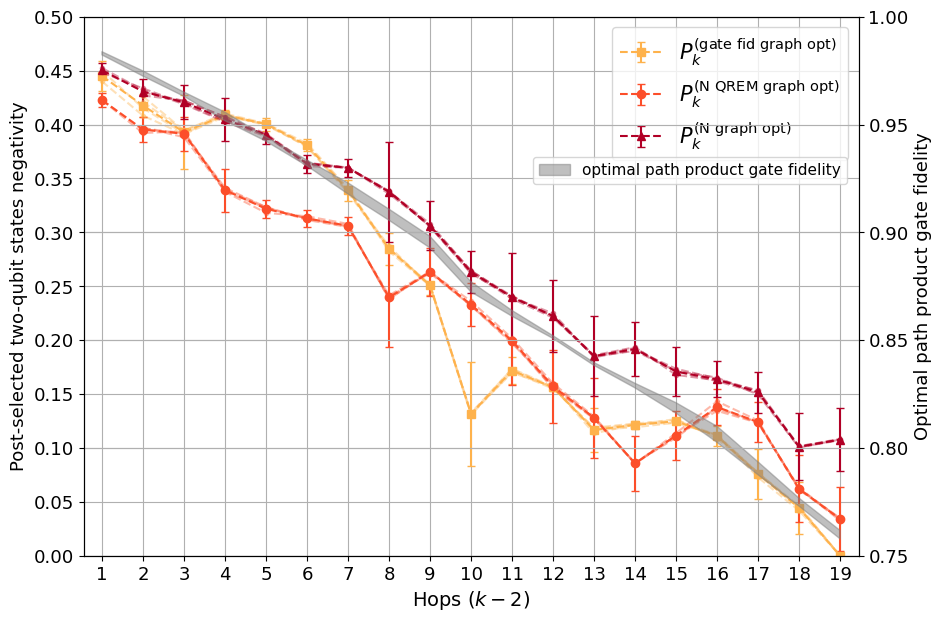

In [28]:
fig, ax = plt.subplots(figsize = (10,7))
ax2 = ax.twinx()

ax.errorbar(gaps, post1_gate_opt, capsize=3, ls='dashed',
            color = '#feb24c', marker = '.', alpha=0.4)

ax.errorbar(gaps, post2_gate_opt, capsize=3, ls='dashed',
            color = '#feb24c', marker = '.', alpha=0.4)

ax.errorbar(gaps[1:], post3_gate_opt[1:], capsize=3, ls='dashed',
            color = '#feb24c', marker = '.', alpha=0.4)

ax.errorbar(gaps[1:], post4_gate_opt[1:], capsize=3, ls='dashed',
            color = '#feb24c', marker = '.', alpha=0.4)

ax.errorbar(gaps, post_gate_opt, yerr=2*np.array(post_gate_opt_err), capsize=3, ls='dashed',
            label = r'$P^{\text{(gate fid graph opt)}}_{k}$', color = '#feb24c', marker = 's')

ax.errorbar(gaps, post1_nmit_opt, capsize=3, ls='dashed',
            color = '#fc4e2a', marker = '.', alpha=0.4)

ax.errorbar(gaps, post2_nmit_opt, capsize=3, ls='dashed',
            color = '#fc4e2a', marker = '.', alpha=0.4)

ax.errorbar(gaps[1:], post3_nmit_opt[1:], capsize=3, ls='dashed',
            color = '#fc4e2a', marker = '.', alpha=0.4)

ax.errorbar(gaps[1:], post4_nmit_opt[1:], capsize=3, ls='dashed',
            color = '#fc4e2a', marker = '.', alpha=0.4)

ax.errorbar(gaps, post_nmit_opt, yerr=2*np.array(post_nmit_opt_err), capsize=3, ls='dashed',
            label = r'$P^{\text{(N QREM graph opt)}}_{k}$', color = '#fc4e2a', marker = 'o')


ax.errorbar(gaps, post1_n_opt, capsize=3, ls='dashed',
            color = '#b10026', marker = '.', alpha=0.4)

ax.errorbar(gaps, post2_n_opt, capsize=3, ls='dashed',
            color = '#b10026', marker = '.', alpha=0.4)

ax.errorbar(gaps[1:], post3_n_opt[1:], capsize=3, ls='dashed',
            color = '#b10026', marker = '.', alpha=0.4)

ax.errorbar(gaps[1:], post4_n_opt[1:], capsize=3, ls='dashed',
            color = '#b10026', marker = '.', alpha=0.4)

ax.errorbar(gaps, post_n_opt, yerr=2*np.array(post_nmit_opt_err), capsize=3, ls='dashed',
            label = r'$P^{\text{(N graph opt)}}_{k}$', color = '#b10026', marker = '^')

ax2.fill_between(gaps, gate_fid-2*np.array(gate_fid_err), gate_fid+2*np.array(gate_fid_err),
                 label = 'optimal path product gate fidelity', color = list(zip(['grey']*19, [0.5]*19)))

ax.set_xticks(np.arange(1, 20, 1))
ax.set_yticks(np.arange(0, 0.6, 0.05))
ax.set_ylim(bottom=0,top=0.5)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid()
ax.margins(0.025, 0.05)
ax.legend(fontsize=15)
ax.set_xlabel(r"Hops $(k-2)$",fontsize=14)
ax.set_ylabel("Post-selected two-qubit states negativity",fontsize=13)

ax2.set_xticks(np.arange(1, 20, 1))
ax2.set_yticks(np.arange(0, 1.1, 0.05))
ax2.set_ylim(bottom=0.75,top=1)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax2.grid()
ax2.margins(0.025, 0.05)
ax2.legend(fontsize=11, loc=(0.58,0.69))
ax2.set_xlabel("Hops",fontsize=13)
ax2.set_ylabel('Optimal path product gate fidelity',fontsize=13)

fig.savefig('optimal paths/sherbrooke data/post selected new/Post Selected Teleported Negativity.pdf', dpi=300, bbox_inches="tight")

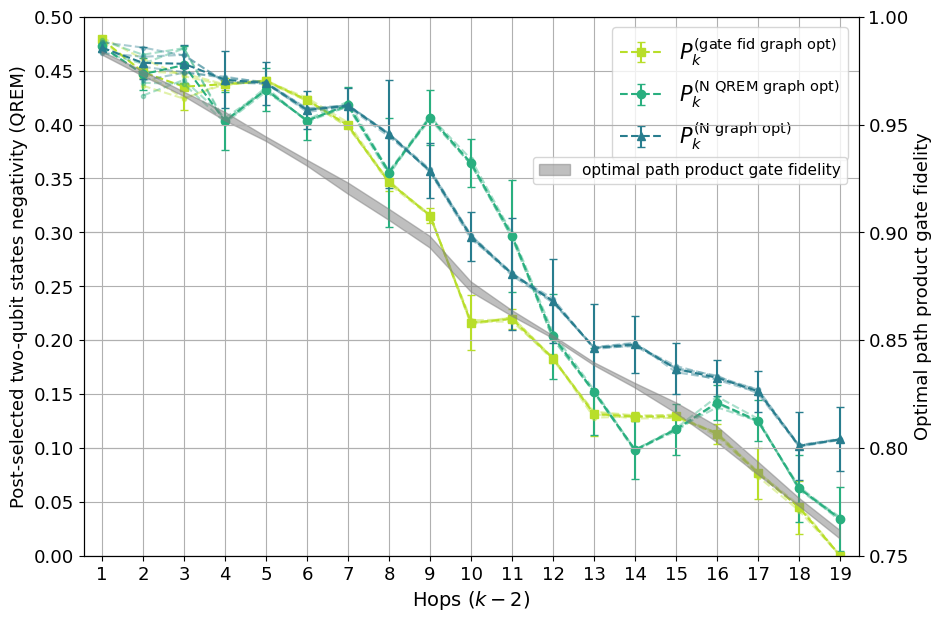

In [30]:
fig, ax = plt.subplots(figsize = (10,7))
ax2 = ax.twinx()

ax.errorbar(gaps, post1_gate_opt, capsize=3, ls='dashed',
            color = '#b8de29ff', marker = '.', alpha=0.4)

ax.errorbar(gaps, post2_gate_opt, capsize=3, ls='dashed',
            color = '#b8de29ff', marker = '.', alpha=0.4)

ax.errorbar(gaps[1:], post3_gate_opt[1:], capsize=3, ls='dashed',
            color = '#b8de29ff', marker = '.', alpha=0.4)

ax.errorbar(gaps[1:], post4_gate_opt[1:], capsize=3, ls='dashed',
            color = '#b8de29ff', marker = '.', alpha=0.4)

ax.errorbar(gaps, post_gate_opt, yerr=2*np.array(post_gate_opt_err), capsize=3, ls='dashed',
            label = r'$P^{\text{(gate fid graph opt)}}_{k}$', color = '#b8de29ff', marker = 's')

ax.errorbar(gaps, post1_nmit_opt, capsize=3, ls='dashed',
            color = '#29af7fff', marker = '.', alpha=0.4)

ax.errorbar(gaps, post2_nmit_opt, capsize=3, ls='dashed',
            color = '#29af7fff', marker = '.', alpha=0.4)

ax.errorbar(gaps[1:], post3_nmit_opt[1:], capsize=3, ls='dashed',
            color = '#29af7fff', marker = '.', alpha=0.4)

ax.errorbar(gaps[1:], post4_nmit_opt[1:], capsize=3, ls='dashed',
            color = '#29af7fff', marker = '.', alpha=0.4)

ax.errorbar(gaps, post_nmit_opt, yerr=2*np.array(post_nmit_opt_err), capsize=3, ls='dashed',
            label = r'$P^{\text{(N QREM graph opt)}}_{k}$', color = '#29af7fff', marker = 'o')


ax.errorbar(gaps, post1_n_opt, capsize=3, ls='dashed',
            color = '#287d8eff', marker = '.', alpha=0.4)

ax.errorbar(gaps, post2_n_opt, capsize=3, ls='dashed',
            color = '#287d8eff', marker = '.', alpha=0.4)

ax.errorbar(gaps[1:], post3_n_opt[1:], capsize=3, ls='dashed',
            color = '#287d8eff', marker = '.', alpha=0.4)

ax.errorbar(gaps[1:], post4_n_opt[1:], capsize=3, ls='dashed',
            color = '#287d8eff', marker = '.', alpha=0.4)

ax.errorbar(gaps, post_n_opt, yerr=2*np.array(post_nmit_opt_err), capsize=3, ls='dashed',
            label = r'$P^{\text{(N graph opt)}}_{k}$', color = '#287d8eff', marker = '^')

ax2.fill_between(gaps, gate_fid-2*np.array(gate_fid_err), gate_fid+2*np.array(gate_fid_err),
                 label = 'optimal path product gate fidelity', color = list(zip(['grey']*19, [0.5]*19)))

ax.set_xticks(np.arange(1, 20, 1))
ax.set_yticks(np.arange(0, 0.6, 0.05))
ax.set_ylim(bottom=0,top=0.5)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid()
ax.margins(0.025, 0.05)
ax.legend(fontsize=15)
ax.set_xlabel(r"Hops $(k-2)$",fontsize=14)
ax.set_ylabel("Post-selected two-qubit states negativity (QREM)",fontsize=13)

ax2.set_xticks(np.arange(1, 20, 1))
ax2.set_yticks(np.arange(0, 1.1, 0.05))
ax2.set_ylim(bottom=0.75,top=1)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax2.grid()
ax2.margins(0.025, 0.05)
ax2.legend(fontsize=11, loc=(0.58,0.69))
ax2.set_xlabel("Hops",fontsize=13)
ax2.set_ylabel('Optimal path product gate fidelity',fontsize=13)

fig.savefig('optimal paths/sherbrooke data/post selected new/Post Selected Teleported Negativity QREM.pdf', dpi=300, bbox_inches="tight")

Dynamic Circuit, 3 optimal protocols, Nmit plot

In [22]:
#Unmitigated
gaps = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
#n_err_opt = [0.405497627, 0.338458348, 0.241876565, 0.204833812, 0.191127871, 0.176698245, 0.178046367, 0.126714169, 0.100240615, 0.060966298, 
#             0.05398638, 0.054340297, 0.047969573, 0.039683896, 0.029480233, 0.025633797, 0.011121779, 0, 0]
#n_err_opt_std = [0.005875421, 0.006391516, 0.033129864, 0.031155247, 0.028833161, 0.02395645, 0.023445852, 0.021370435, 0.018202091, 0.012463139, 
#                 0.009523567, 0.009986502, 0.007787518, 0.006167243, 0.004193714, 0.004151297, 0.003065054, 0, 0]
#n_nmit_opt = [0.301085954, 0.292648403, 0.213171682, 0.192320508, 0.222616543, 0.196854971, 0.170177758, 0.166751976, 0.145855764, 0.128874886, 
#              0.153265343, 0.117406778, 0.054392255, 0.024026156, 0.007026405, 0.002145964, 0.001269182, 0, 0]
#n_nmit_opt_std = [0.014595475, 0.016302778, 0.0146156, 0.015084368, 0.013859213, 0.013153443, 0.014910607, 0.013659584, 0.01056711, 0.007472251, 
#                  0.006337657, 0.008334672, 0.011417035, 0.009352414, 0.001774115, 0.001282543, 0.000783218, 0, 0]
#n_n_opt = [0.372184281, 0.348324196, 0.310243157, 0.288665786, 0.249776743, 0.170150231, 0.153962048, 0.135204939, 0.163726951, 0.105854414, 0.083117741, 
#           0.06935403, 0.046824625, 0.017007392, 0.016208564, 0.001321862, 0.00329957, 0, 0.003249589]
#n_n_opt_std = [0.017148878, 0.009244351, 0.00499573, 0.008068576, 0.011956957, 0.020089486, 0.015182497, 0.023157052, 0.013524726, 0.011215329, 
#               0.0037223, 0.011028408, 0.006241089, 0.004312051, 0.003617721, 0.000748806, 0.001160709, 0, 0.002151244]

n_err_opt = [0.304345194, 0.245245739, 0.269170392, 0.157261605, 0.149879745, 0.068658572, 0.129795988, 0.056035899, 0.14666209, 
             0.087229385, 0.097410333, 0.041432681, 0.034188577, 0.011256005, 0.007371261, 0.000107945, 0, 0, 0]
n_err_opt_std = [0.030075697, 0.024370413, 0.009090971, 0.030525616, 0.014070667, 0.016904844, 0.018033986, 0.014777931, 
                 0.004279313, 0.012201074, 0.008431399, 0.010627875, 0.006939566, 0.003737102, 0.004004617, 0.000104517, 0, 0, 0]
n_nmit_opt =  [0.322955099, 0.278063285, 0.288670574, 0.252948732, 0.164824679, 0.145450654, 0.199469863, 0.205187451, 0.20086907, 
               0.138362955, 0.100935574, 0.073794315, 0.016179014, 0.028849171, 0.005530828, 0, 0.002449725, 0.001284076, 0]
n_nmit_opt_std = [0.019018655, 0.022772955, 0.014570072, 0.013543599, 0.026292425, 0.022339475, 0.007619089, 0.006213459, 0.006053646,
                  0.014064835, 0.017031728, 0.011526026, 0.00641849, 0.010394461, 0.003607179, 0, 0.001625869, 0.000658662, 0]
n_n_opt = [0.3876333, 0.319455025, 0.272247869, 0.203285131, 0.171450658, 0.137396527, 0.133293569, 0.128410189, 0.131184833, 0.129409906, 
           0.101104263, 0.081003425, 0.042500834, 0.024407517, 0.024652769, 0.007144914, 0.016315922, 0.0059555, 0]
n_n_opt_std = [0.009167047, 0.012859924, 0.024568988, 0.025818366, 0.029000615, 0.02113053, 0.012613063, 0.015717535, 0.01884033, 
               0.016972996, 0.012306328, 0.012842728, 0.011450571, 0.010432873, 0.007091889, 0.003782976, 0.005478856, 0.002062657, 0]
gate_fid = [0.983973972, 0.975108218, 0.964404411, 0.953915974, 0.941957689, 0.92787784, 0.914815291, 0.903003837, 0.891051833, 0.882692039, 
            0.874045063, 0.863369911, 0.853177051, 0.841824725, 0.830118088, 0.817273486, 0.8059795, 0.796363575, 0.78830851]
gate_fid_std = [0.0003621093521562745, 0.000411615909786362, 0.0007807367892184382, 0.001130593392654441, 0.0008640924093577085, 0.0010978948728699682, 
                0.0012106742840990508, 0.0005920396385946204, 0.0005042761013987537, 0.0006417900475188031, 0.0006389992681592818, 0.0012798008857343981, 
                0.0013993510351013989, 0.00039188234555440136, 0.001279198814199785, 0.0007422480727869798, 0.0005499803665214145, 0.0005801789817494208, 
                0.0005410521708354802]

In [25]:
#Mitigated
gaps = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
#n_err_opt = [0.42967303, 0.350560148, 0.26935832, 0.217773994, 0.200384712, 0.188019185, 0.208584774, 
#             0.140906081, 0.121903418, 0.074558378, 0.055424818, 0.056061076, 0.049083287, 0.039880192, 
#             0.029679123, 0.025480538, 0.010901089, 0, 0]
#n_err_opt_std = [0.005195861, 0.006558376, 0.036214355, 0.03285918, 0.03004986, 0.024452709, 0.026413201, 
#                 0.024084108, 0.02107317, 0.014329513, 0.009717441, 0.009844392, 0.007804165, 0.0061798, 0.004175089, 
#                 0.004141442, 0.00301948, 0, 0]
#n_nmit_opt = [0.389550107, 0.325158024, 0.245179799, 0.232259698, 0.245472318, 0.2643624, 0.191509408, 0.197886315, 0.174106621, 0.153575706,
#              0.161975187, 0.12832222, 0.063803512, 0.026423697, 0.007032044, 0.002555222, 0.001444116, 0, 0]
#n_nmit_opt_std = [0.015609997,0.013367848,0.014218331,0.013553318,0.015374299,0.02454718,0.01380602,0.01464306,
#                  0.008181019,0.006751696,0.004685294,0.009618404,0.013062989,0.010641803,0.001726542,0.001219479,0.000849147,0,0]
#n_n_opt = [0.424734529,0.363053384,0.326780374,	0.305321026,0.262675029,0.179347139,0.16461422,0.14544973,0.172469935,0.110627227,0.087840351,
#           0.07092106,0.047208508,0.017428493,0.01634467,0.001367696,0.003222118,0,0.003258317]
#n_n_opt_std = [0.008536719,0.009857565,0.005346876,0.009175427,0.012165181,0.021009604,0.015148389,0.024334434,0.013922009,0.011565187,0.006028611,
#               0.011138205,0.006297029,0.004362441,0.003637325,0.00076545,0.001134253,0,0.002156902]

n_err_opt = [0.336993986, 0.265487585, 0.290739858, 0.164182295, 0.17350246, 0.08048024, 0.140266321, 0.068422553, 0.159389734, 0.093436045, 0.100158219, 
             0.042157535, 0.034707266, 0.011392974, 0.007398152, 9.61E-05, 0, 0, 0]
n_err_opt_std = [0.032798432, 0.0262963, 0.006338855, 0.031659689, 0.015462042, 0.018925031, 0.017549077, 0.017305366, 0.005387728, 
                 0.012322388, 0.008824221, 0.010835447, 0.006978495, 0.003807398, 0.00400812, 9.30E-05, 0, 0, 0]
n_nmit_opt = [0.365679403, 0.303197582, 0.315766579, 0.275273004, 0.20078297, 0.159947047, 0.210731104, 0.220155147, 0.209464771, 
              0.143672253, 0.104554117, 0.081983044, 0.017140629, 0.029103508, 0.005702294, 0, 0.002451742, 0.001277982, 0]
n_nmit_opt_std = [0.018890411, 0.021903251, 0.012031913, 0.012186292, 0.031209677, 0.022659929, 0.007700147, 0.007344089, 0.00591338, 
                  0.013724282, 0.017319238, 0.014157877, 0.00657174, 0.010459139, 0.003645571, 0, 0.001627098, 0.000656794, 0]
n_n_opt = [0.413395665, 0.342285952, 0.282690789, 0.212457951, 0.179298117, 0.146739941, 0.14241981, 0.138476451, 0.136905939, 0.132742423, 0.104344199,
           0.082847038, 0.043124555, 0.024494525, 0.02464205, 0.007164558, 0.016325828, 0.005957191, 0]
n_n_opt_std = [0.010529884, 0.015521378, 0.024971979, 0.026462156, 0.029462473, 0.022478838, 0.012586903, 0.017012686, 0.018750543, 0.017274302, 
               0.012457962, 0.013073506, 0.011536215, 0.010452368, 0.007081405, 0.003775251, 0.005473417, 0.002062672, 0]
gate_fid = [0.983973972, 0.975108218, 0.964404411, 0.953915974, 0.941957689, 0.92787784, 0.914815291, 0.903003837, 0.891051833, 0.882692039, 
            0.874045063, 0.863369911, 0.853177051, 0.841824725, 0.830118088, 0.817273486, 0.8059795, 0.796363575, 0.78830851]
gate_fid_std = [0.0003621093521562745, 0.000411615909786362, 0.0007807367892184382, 0.001130593392654441, 0.0008640924093577085, 0.0010978948728699682, 
                0.0012106742840990508, 0.0005920396385946204, 0.0005042761013987537, 0.0006417900475188031, 0.0006389992681592818, 0.0012798008857343981, 
                0.0013993510351013989, 0.00039188234555440136, 0.001279198814199785, 0.0007422480727869798, 0.0005499803665214145, 0.0005801789817494208, 
                0.0005410521708354802]

[1.88990038 0.19039645 1.46176851]
[ 0.30545509  0.34845226 -2.98163353]
[1.41597479e+04 1.66602890e-01 1.03716619e+01]
characteristic decay rate gate error optimal: 0.19039645264555752, standard error: 0.07408906900915903
characteristic decay rate Nmit graph optimal: 0.34845226298798176, standard error: 0.0923189571469429
characteristic decay rate N graph optimal: 0.16660288952813296, standard error: 0.037894261297351926


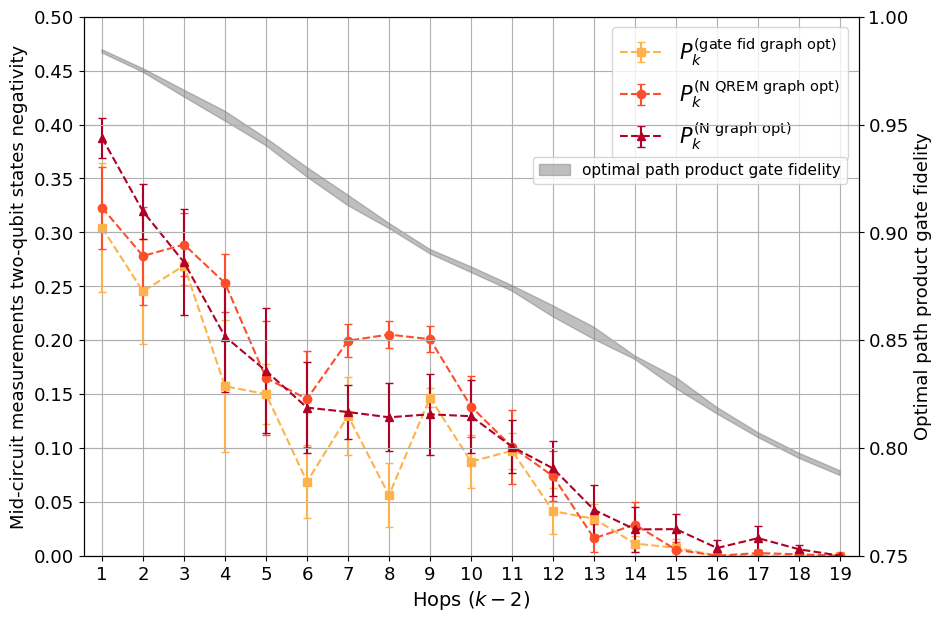

In [24]:
figsize = (10, 7)
fig, ax = plt.subplots(figsize = figsize)
ax2 = ax.twinx()
fitted_params_err_opt, pcov_err_opt = opt.curve_fit(logit_fit, gaps, n_err_opt, p0=[1,0.2,-1], maxfev=10000)
fitted_params_nmit_opt, pcov_nmit_opt = opt.curve_fit(logit_fit, gaps, n_nmit_opt, p0=[1,0.2,-1], maxfev=10000)
fitted_params_n_opt, pcov_n_opt = opt.curve_fit(logit_fit, gaps, n_n_opt, p0=[1,0.2,-1], maxfev=10000)
print(fitted_params_err_opt)
print(fitted_params_nmit_opt)
print(fitted_params_n_opt)

fit_gaps = np.linspace(1,20,1000)
print(f'characteristic decay rate gate error optimal: {fitted_params_err_opt[1]}, standard error: {np.sqrt(pcov_err_opt[1][1])}')
print(f'characteristic decay rate Nmit graph optimal: {fitted_params_nmit_opt[1]}, standard error: {np.sqrt(pcov_nmit_opt[1][1])}')
print(f'characteristic decay rate N graph optimal: {fitted_params_n_opt[1]}, standard error: {np.sqrt(pcov_n_opt[1][1])}')


ax.errorbar(gaps, n_err_opt, yerr=2*np.array(n_err_opt_std), capsize=3, ls='dashed',
            label = r'$P^{\text{(gate fid graph opt)}}_{k}$', color = '#feb24c', marker = 's')
ax.errorbar(gaps, n_nmit_opt, yerr=2*np.array(n_nmit_opt_std), capsize=3, ls='dashed',
            label = r'$P^{(\text{N QREM graph opt})}_{k}$', color = '#fc4e2a', marker = 'o')
ax.errorbar(gaps, n_n_opt, yerr=2*np.array(n_n_opt_std), capsize=3, ls='dashed',
            label = r'$P^{(\text{N graph opt})}_{k}$', color = '#b10026', marker = '^')

ax2.fill_between(gaps, gate_fid-2*np.array(gate_fid_std), gate_fid+2*np.array(gate_fid_std),
                 label = 'optimal path product gate fidelity', color = list(zip(['grey']*19, [0.5]*19)))
#ax.plot(fit_gaps, logit_fit(fit_gaps, *fitted_params_err_opt), color = 'darkgreen', ls='dashed')
#ax.plot(fit_gaps, logit_fit(fit_gaps, *fitted_params_nmit_opt), color = 'limegreen', ls='dashed')
#ax.plot(fit_gaps, logit_fit(fit_gaps, *fitted_params_n_opt), color = 'greenyellow', ls='dashed')

#ax.axhline(y=0.5, color='black')
#ax.plot(net_error_fit, fit(net_error_fit, *fitted_params_Fid), color = 'red', linestyle = 'dashed')
#ax.plot(net_error_fit, fit(net_error_fit, *fitted_params_Fid_mit), color = 'blue', linestyle = 'dashed')
ax.set_xticks(np.arange(1, 20, 1))
ax.set_yticks(np.arange(0, 0.6, 0.05))
ax.set_ylim(bottom=0,top=0.5)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid()
ax.margins(0.025, 0.05)
ax.legend(fontsize=15)
ax.set_xlabel(r"Hops $(k-2)$",fontsize=14)
ax.set_ylabel('Mid-circuit measurements two-qubit states negativity',fontsize=13)

ax2.set_xticks(np.arange(1, 20, 1))
ax2.set_yticks(np.arange(0, 1.1, 0.05))
ax2.set_ylim(bottom=0.75,top=1)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax2.grid()
ax2.margins(0.025, 0.05)
ax2.legend(fontsize=11, loc=(0.58,0.69))
ax2.set_xlabel("Hops",fontsize=13)
ax2.set_ylabel('Optimal path product gate fidelity',fontsize=13)

fig.savefig('optimal paths/sherbrooke data/dynamic circuits new/Dynamic Circuits Teleported Negativity.pdf', dpi=300, bbox_inches="tight")

[1.84610305 0.19337059 1.32185573]
[ 0.35932513  0.32550901 -2.56296596]
[1.80826380e+04 1.69270109e-01 1.05510344e+01]
characteristic decay rate gate error optimal: 0.19337059321969205, standard error: 0.07151599238646801
characteristic decay rate Nmit graph optimal: 0.3255090071589959, standard error: 0.07880956730453399
characteristic decay rate N graph optimal: 0.169270109178971, standard error: 0.037652438241705326


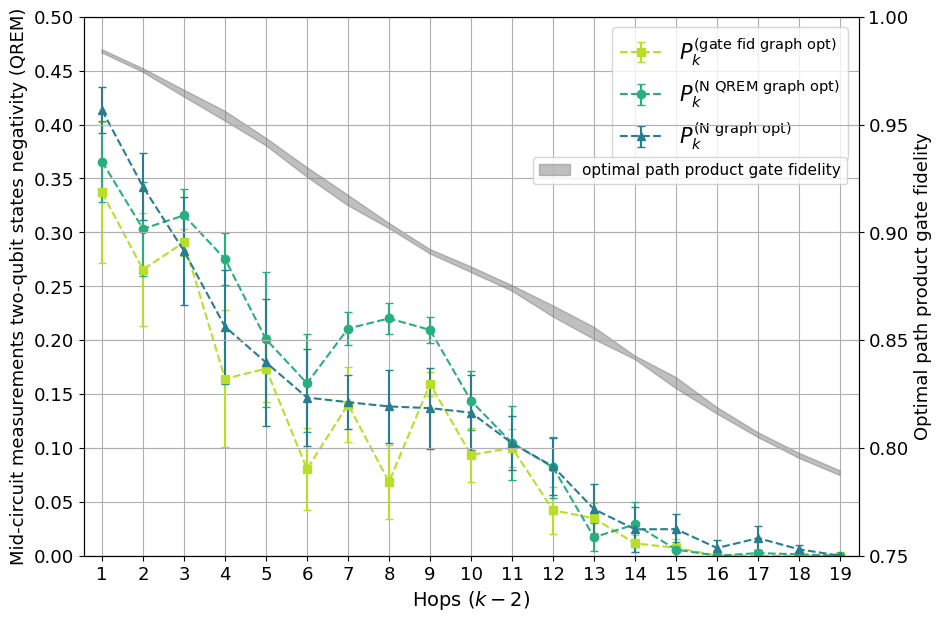

In [26]:
figsize = (10, 7)
fig, ax = plt.subplots(figsize = figsize)
ax2 = ax.twinx()
fitted_params_err_opt, pcov_err_opt = opt.curve_fit(logit_fit, gaps, n_err_opt, p0=[1,0.2,-1], maxfev=10000)
fitted_params_nmit_opt, pcov_nmit_opt = opt.curve_fit(logit_fit, gaps, n_nmit_opt, p0=[1,0.2,-1], maxfev=10000)
fitted_params_n_opt, pcov_n_opt = opt.curve_fit(logit_fit, gaps, n_n_opt, p0=[1,0.2,-1], maxfev=10000)
print(fitted_params_err_opt)
print(fitted_params_nmit_opt)
print(fitted_params_n_opt)

fit_gaps = np.linspace(1,20,1000)
print(f'characteristic decay rate gate error optimal: {fitted_params_err_opt[1]}, standard error: {np.sqrt(pcov_err_opt[1][1])}')
print(f'characteristic decay rate Nmit graph optimal: {fitted_params_nmit_opt[1]}, standard error: {np.sqrt(pcov_nmit_opt[1][1])}')
print(f'characteristic decay rate N graph optimal: {fitted_params_n_opt[1]}, standard error: {np.sqrt(pcov_n_opt[1][1])}')


ax.errorbar(gaps, n_err_opt, yerr=2*np.array(n_err_opt_std), capsize=3, ls='dashed',
            label = r'$P^{\text{(gate fid graph opt)}}_{k}$', color = '#b8de29ff', marker = 's')
ax.errorbar(gaps, n_nmit_opt, yerr=2*np.array(n_nmit_opt_std), capsize=3, ls='dashed',
            label = r'$P^{(\text{N QREM graph opt})}_{k}$', color = '#29af7fff', marker = 'o')
ax.errorbar(gaps, n_n_opt, yerr=2*np.array(n_n_opt_std), capsize=3, ls='dashed',
            label = r'$P^{(\text{N graph opt})}_{k}$', color = '#287d8eff', marker = '^')
ax2.fill_between(gaps, gate_fid-2*np.array(gate_fid_std), gate_fid+2*np.array(gate_fid_std),
                 label = 'optimal path product gate fidelity', color=list(zip(['grey']*19, [0.5]*19)))
#ax.plot(fit_gaps, logit_fit(fit_gaps, *fitted_params_err_opt), color = 'darkgreen', ls='dashed')
#ax.plot(fit_gaps, logit_fit(fit_gaps, *fitted_params_nmit_opt), color = 'limegreen', ls='dashed')
#ax.plot(fit_gaps, logit_fit(fit_gaps, *fitted_params_n_opt), color = 'greenyellow', ls='dashed')

#ax.axhline(y=0.5, color='black')
#ax.plot(net_error_fit, fit(net_error_fit, *fitted_params_Fid), color = 'red', linestyle = 'dashed')
#ax.plot(net_error_fit, fit(net_error_fit, *fitted_params_Fid_mit), color = 'blue', linestyle = 'dashed')
ax.set_xticks(np.arange(1, 20, 1))
ax.set_yticks(np.arange(0, 0.6, 0.05))
ax.set_ylim(bottom=0,top=0.5)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid()
ax.margins(0.025, 0.05)
ax.legend(fontsize=15)
ax.set_xlabel(r"Hops $(k-2)$",fontsize=14)
ax.set_ylabel('Mid-circuit measurements two-qubit states negativity (QREM)',fontsize=13)

ax2.set_xticks(np.arange(1, 20, 1))
ax2.set_yticks(np.arange(0, 1.1, 0.05))
ax2.set_ylim(bottom=0.75,top=1)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax2.grid()
ax2.margins(0.025, 0.05)
ax2.legend(fontsize=11, loc=(0.58,0.69))
ax2.set_xlabel("Hops",fontsize=13)
ax2.set_ylabel('Optimal path product gate fidelity',fontsize=13)

fig.savefig('optimal paths/sherbrooke data/dynamic circuits new/Dynamic Circuits Teleported Negativity QREM.pdf', dpi=300, bbox_inches="tight")